### NOTE: This notebook was originally ran using python 3.11.3

# GET EVERYTHING READY

In [208]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
from IPython.display import display
from PIL import Image

# R stuff:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Set seaborn theme and context
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [209]:
# READ the data:
main_data_df = pd.read_pickle('parsed_data/main_data_df.pkl')
CT_data = pd.read_pickle('parsed_data/CT_data.pkl')
gambles = pd.read_pickle('parsed_data/gambles.pkl')

main_data_df = main_data_df.reset_index(drop=True)
CT_data = CT_data.reset_index(drop=True)
gambles = gambles.reset_index(drop=True)

# Helper functions for IPI calculations:
# -----------------------------
def extractCorrectKeyPresses(seq, presses):
    trial_key_presses = presses.copy()
    # remove key presses woth key_rt = None:
    trial_key_presses = [
        x for x in trial_key_presses if x['key_rt'] is not None]
    correct_presses = []
    min_loc_to_look = 0  # used to verify the order of the keys.
    if trial_key_presses:
        for i in range(len(seq)):
            trial_key_presses = trial_key_presses[min_loc_to_look:]
            if seq[i] in [x['key_pressed'] for x in trial_key_presses]:
                loc = [x['key_pressed']
                       for x in trial_key_presses].index(seq[i])
                correct_presses.append(trial_key_presses[loc])
                min_loc_to_look = loc + 1
    return correct_presses


def calculateIPIs(key_presses):
    ipis = np.nan
    if len(key_presses) == 3:
        IPI1 = key_presses[1]['key_rt'] - key_presses[0]['key_rt']
        IPI2 = key_presses[2]['key_rt'] - key_presses[1]['key_rt']
        ipis = [IPI1, IPI2]
    return ipis


def calc_IPI_Consistency(input_data, seperate_by_block=False):
    # cerate a copy of the data
    data = input_data.copy()
    for i in range(1, len(data)):
        row1 = data.iloc[i-1]
        row2 = data.iloc[i]
        isSameBlock = row1['block'] == row2['block']
        if row1['sub'] == row2['sub'] and row1['stimType'] == row2['stimType'] and \
                isinstance(row1['inter_press_intervals'], list) and isinstance(row2['inter_press_intervals'], list) and \
                row1['inter_press_intervals'] and row2['inter_press_intervals']:
            if not seperate_by_block or isSameBlock:
                # display(row1['inter_press_intervals'])
                # display(row2['inter_press_intervals'])
                IPI_1_abs_diff = abs(
                    row2['inter_press_intervals'][0] - row1['inter_press_intervals'][0])
                IPI_2_abs_diff = abs(
                    row2['inter_press_intervals'][1] - row1['inter_press_intervals'][1])
                # calculate the sum of the absolute difference between the IPIs:
                IPI_abs_diff_sum = IPI_1_abs_diff + IPI_2_abs_diff

                # add it to the dataframe:
                data.loc[i, 'IPI_abs_diff_sum'] = IPI_abs_diff_sum
    return data


# Create the IPI data:
# -----------------------------
IPI_consistency_data = main_data_df[main_data_df['blockType'] != 'gambles_only'].copy()

# create a new column based on SRO_keyPressSummary that includes only the correct sequence pressing (according to stim_seq)
IPI_consistency_data.loc[:, 'SRO_keyPressSummary_correct'] = IPI_consistency_data.apply(lambda row: extractCorrectKeyPresses(row['stim_seq'], row['SRO_keyPressSummary']), axis=1)
IPI_consistency_data.loc[:, 'inter_press_intervals'] = IPI_consistency_data.apply(lambda row: calculateIPIs(row['SRO_keyPressSummary_correct']), axis=1)

# Create a new dataframes with the IPIs (with and without block seperation)
sorted_IPI_consistency_data = IPI_consistency_data.sort_values(by=['sub', 'stimType', 'block', 'trial'])
sorted_IPI_consistency_data = sorted_IPI_consistency_data.reset_index(drop=True)

# add absolute stimulus trial number:
sorted_IPI_consistency_data.loc[:, 'stim_abs_trial'] = sorted_IPI_consistency_data.groupby(['sub', 'stimType']).cumcount() + 1

IPI_consistency_data_by_trial = calc_IPI_Consistency(sorted_IPI_consistency_data, seperate_by_block=False)
IPI_consistency_data_w_block_sep = calc_IPI_Consistency(sorted_IPI_consistency_data, seperate_by_block=True)


# add time befroe/after (deval) to main_data_df:
# -----------------------------------------------
main_data_df['time'] = np.nan
main_data_df.loc[main_data_df['phase'] == 'pre_test', 'time'] = 'before'
main_data_df.loc[main_data_df['phase'] == 'test', 'time'] = 'after'
main_data_df.loc[main_data_df['phase'] == 'reacquisition', 'time'] = 'after'
main_data_df.loc[:, ['sub', 'phase', 'time']].tail(100)

main_data_df = main_data_df.reset_index(drop=True)


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3197255455.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'before' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_data_df.loc[main_data_df['phase'] == 'pre_test', 'time'] = 'before'


# FUNCTIONS

In [210]:
def prepare_local_std(data, var_of_comparison=None, var = None, smoothing_window=5):
    # remove'_std' from the var name:
    var = var.split('_local_std')[0]
    data = data.copy()
    # remove reward type rock:
    data = data[data['rewardType'] != 'rock']

    # smooth the data:
    if var_of_comparison is not None:
        data.loc[:, var + '_local_std'] = data.groupby(['sub', 'stim_condition'])[var].transform(lambda x: x.rolling(smoothing_window).std())
    else:
        data.loc[:, var + '_local_std'] = data.groupby(['sub'])[var].transform(lambda x: x.rolling(smoothing_window).std())
    
    # remove nan values:
    data = data[data[var + '_local_std'].notna()].reset_index(drop=True)

    data.loc[:, 'stim_abs_trial'] = data.groupby(['sub', 'stimType']).cumcount()
    return data


def plotTimeVarGroups(data, var_of_interest='SRO_seq_completion_time', time_var='block', var_of_comparison='rewardType', include_never_valued=False, hue_order=['blue', 'red'], pallette=['blue', 'red'], statistic='mean', include_test_pahse=True, y_label=None):
    if time_var == 'phase':
        data.loc[:, time_var] = pd.Categorical(data[time_var], categories=[
                                               'pre_test', 'test', 'reacquisition'], ordered=True)

    # get only trials with a reward type blue or red:
    if include_never_valued:
        relevant_data = data[data['rewardType'].isin(['blue', 'red', 'rock'])]
    else:
        relevant_data = data[data['rewardType'].isin(['blue', 'red'])]
    # remove trials with seq completion, i.e. there is no nan in the var_of_interest column:
    relevant_data = relevant_data[~relevant_data[var_of_interest].isna()].reset_index(drop=True)
    if not include_test_pahse:
        relevant_data = relevant_data[relevant_data['phase'] != 'test']
        relevant_data = relevant_data[relevant_data['phase'] != 'reacquisition'].reset_index(drop=True)
    # calclulate the relevant measure:
    if statistic == 'mean':
        if var_of_comparison is None:
            # if var_of_comparison is None, then we want to calculate the mean for each sub and block:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var])[var_of_interest].mean()
        else:
            # calculate the average seq completion time per sub prer block per reward type:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var, var_of_comparison])[var_of_interest].mean()
    elif statistic == 'STD':
        if var_of_comparison is None:
            # if var_of_comparison is None, then we want to calculate the std for each sub and block:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var])[var_of_interest].std()
        else:
            # calculate the variance of seq completion time per sub prer block per reward type:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var, var_of_comparison])[var_of_interest].std()

    relevant_data_summary = relevant_data_summary.reset_index()

    # Separate the data for the "short" group
    short_group = relevant_data_summary[relevant_data_summary['group'] == 'short']
    blockNumbers_short = short_group[time_var].unique()
    x_ticks_loc_short = [x for x in range(len(blockNumbers_short))]
    short_group.loc[:, time_var] = short_group[time_var].replace(
        blockNumbers_short, x_ticks_loc_short)

    # Separate the data for the "more_extensive" group
    more_extensive_group = relevant_data_summary[relevant_data_summary['group']
                                                == 'more_extensive']
    blockNumbers_more_extensive = more_extensive_group[time_var].unique()
    x_ticks_loc_more_extensive = [
        x for x in range(len(blockNumbers_more_extensive))]
    more_extensive_group.loc[:, time_var] = more_extensive_group[time_var].replace(
        blockNumbers_more_extensive, x_ticks_loc_more_extensive)
    
    relevant_data_summary.loc[:, time_var] = relevant_data_summary[time_var].replace(
        blockNumbers_more_extensive, x_ticks_loc_more_extensive)

    if var_of_comparison is not None:

        # Plotting
        # -----------------------------
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        # Plot for the "short" group
        sns.lineplot(data=short_group, x=time_var, y=var_of_interest, hue=var_of_comparison,
                    hue_order=hue_order, palette=pallette, ax=axes[0], legend=False, errorbar=('se', 1))
        sns.lineplot(data=short_group, x=time_var, y=var_of_interest, hue=var_of_comparison, hue_order=hue_order,
                    style='sub', markers=True, dashes=False, alpha=0.01, legend=False, palette=pallette, ax=axes[0])
        axes[0].set_title('Short training')
        axes[0].set_xlabel(time_var)
        if y_label is not None:
            axes[0].set_ylabel(y_label)
        else:
            axes[0].set_ylabel(f'{statistic} {var_of_interest}')
        axes[0].set_xticks(x_ticks_loc_short)
        axes[0].set_xticklabels(blockNumbers_short)

        # Plot for the "more_extensive" group
        sns.lineplot(data=more_extensive_group, x=time_var, y=var_of_interest, hue=var_of_comparison,
                    hue_order=hue_order, palette=pallette, ax=axes[1], errorbar=('se', 1))
        sns.lineplot(data=more_extensive_group, x=time_var, y=var_of_interest, hue=var_of_comparison, hue_order=hue_order,
                    style='sub', markers=True, dashes=False, alpha=0.01, legend=False, palette=pallette, ax=axes[1])
        axes[1].set_title('Extensive training')
        axes[1].set_xlabel(time_var)
        axes[1].set_xticks(x_ticks_loc_more_extensive)
        axes[1].set_xticklabels(blockNumbers_more_extensive)
    else:
        label_map = {
            'short': 'Short training',
            'more_extensive': 'Extensive training'
            }
        plot_df = relevant_data_summary.copy()
        plot_df['group'] = plot_df['group'].map(label_map)
        group_palette = {
            'Short training': 'blue',         
            'Extensive training': 'red'      
        }

        # Plotting without var_of_comparison
        # -----------------------------
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        sns.lineplot(data=plot_df, x=time_var, y=var_of_interest,
                    hue='group', palette=group_palette, ax=axes, errorbar='se', hue_order = ['Short training', 'Extensive training'])

        axes.set_xlabel('Block')
        if y_label is not None:
            axes.set_ylabel(y_label)
        else:
            axes.set_ylabel(f'{statistic} {var_of_interest}')
        axes.set_xticks(x_ticks_loc_more_extensive)
        axes.set_xticklabels(blockNumbers_more_extensive)
        legend = axes.legend(title="Group")

    # plt.tight_layout()
    plt.show()


# fit an exponential decay to the data:
# -------------------------------------------
def exponential_decay(x, asymp_to, improvement, alpha):
    return asymp_to + improvement * np.exp(-alpha * x)


# EXCLUSIONS

## Get exclusions

In [211]:
PRE_REG_EXCLUSIONS = {}

# get the number of n_pressing_gambleKeys_in_SRO as a table:
n_pressing_gambleKeys_in_SRO_summary = main_data_df.groupby(['group', 'sub', 'block'])['n_pressing_gambleKeys_in_SRO'].sum()
n_pressing_gambleKeys_in_SRO_summary = n_pressing_gambleKeys_in_SRO_summary.reset_index()
# make block values columns:
n_pressing_gambleKeys_in_SRO_summary_table = n_pressing_gambleKeys_in_SRO_summary.pivot(index='sub', columns='block', values='n_pressing_gambleKeys_in_SRO')
PRE_REG_EXCLUSIONS['has_a_block_with_more_than_50_gamble_key_presses_during_SRO'] = sorted(n_pressing_gambleKeys_in_SRO_summary.loc[n_pressing_gambleKeys_in_SRO_summary['n_pressing_gambleKeys_in_SRO'] > 50, 'sub'].unique().tolist())

# get the number of trials with at least one pressing of gamble keys:
trial_prop_w_gambleKeys_in_SRO = main_data_df.groupby(['group', 'sub', 'block'])['n_pressing_gambleKeys_in_SRO'].apply(lambda x: ((x > 0).sum() / len(x)).round(2)).reset_index()
# make block values columns:
trial_prop_w_gambleKeys_in_SRO_table = trial_prop_w_gambleKeys_in_SRO.pivot(index='sub', columns='block', values='n_pressing_gambleKeys_in_SRO')
PRE_REG_EXCLUSIONS['has_an_SRO_block_with_at_more_than_50_percent_trials_with_gamble_key_presses'] = sorted(trial_prop_w_gambleKeys_in_SRO.loc[trial_prop_w_gambleKeys_in_SRO['n_pressing_gambleKeys_in_SRO'] > 0.5, 'sub'].unique().tolist())
                   
# get the number of times 'choice_rt' is smaller than 200, per sub per block:
n_fast_choice_rt_summary = main_data_df.groupby(['group', 'sub', 'block'])['choice_rt'].apply(lambda x: ((x <= 200).sum() / len(x)).round(2))
n_fast_choice_rt_summary = n_fast_choice_rt_summary.reset_index()
# make block values columns:
n_fast_choice_rt_summary_table = n_fast_choice_rt_summary.pivot(index='sub', columns='block', values='choice_rt')
PRE_REG_EXCLUSIONS['has_amore_than_50_percent_gamble_trials_with_RT_less_than_200ms'] = sorted(n_fast_choice_rt_summary.loc[n_fast_choice_rt_summary['choice_rt'] > 0.5, 'sub'].unique().tolist())

# Get low SRO (Stimulus-Response-Outcome, i.e., operant learning part) engagement:
relev_SRO_data = main_data_df.loc[(main_data_df.stimType == 'planet_red') | (main_data_df.stimType == 'planet_blue'),:].copy().reset_index(drop=True)
# remove phase 'test' and 'reacquisition' (2nd test block):
relev_SRO_data = relev_SRO_data.loc[(relev_SRO_data.phase != 'test') & (relev_SRO_data.phase != 'reacquisition'),:].copy().reset_index(drop=True)
# Now for each sub, block, and group, calculate the proportion of SRO trials with sequenceCompleted:
SRO_response_rate = relev_SRO_data.groupby(['group', 'sub'])['sequenceCompleted'].apply(lambda x: (x.sum() / len(x)).round(2)).reset_index()
PRE_REG_EXCLUSIONS['has_less_than_60percent_Relevant_SRO_trials_with_sequenceCompleted'] = sorted(SRO_response_rate.loc[SRO_response_rate.sequenceCompleted < 0.6, 'sub'].unique().tolist())

# Get engagement toward the (never valued) YELLOW SRO trials:
relev_YELLOW_SRO_data = main_data_df.loc[main_data_df.stimType == 'planet_yellow',:].copy().reset_index(drop=True)
# Now for each sub, block, and group, calculate the proportion of SRO trials with sequenceCompleted:
SRO_YELLOW_response_rate = relev_YELLOW_SRO_data.groupby(['group', 'sub'])['sequenceCompleted'].apply(lambda x: (x.sum() / len(x)).round(2)).reset_index()
PRE_REG_EXCLUSIONS['has_more_than_40percent_Relevant_YELLOW_SRO_trials_with_sequenceCompleted'] = sorted(SRO_YELLOW_response_rate.loc[SRO_YELLOW_response_rate.sequenceCompleted > 0.4, 'sub'].unique().tolist())

# Get low response rate in gamble trials:
relev_gamble_data = main_data_df.loc[main_data_df.blockType != 'SRO_only',:].copy().reset_index(drop=True)
# Now for each sub, and group, calculate the proportion of SRO trials with sequenceCompleted:
Gamble_response_rate = relev_gamble_data.groupby(['group', 'sub'])['choice_rt'].apply(lambda x: (x.notnull().sum() / len(x)).round(2)).reset_index()
PRE_REG_EXCLUSIONS['has_less_than_60percent_Relevant_Gamble_trials_with_choice_rt'] = sorted(Gamble_response_rate.loc[Gamble_response_rate.choice_rt < 0.6, 'sub'].unique().tolist())


In [212]:
# now combine everything in PRE_REG_EXCLUSIONS to one list (ubique subjects) and sorted:
PRE_REG_EXCLUSIONS_LIST = sorted(set([item for sublist in PRE_REG_EXCLUSIONS.values() for item in sublist]))
print('Exlusions:', PRE_REG_EXCLUSIONS_LIST)
print('n_excluded:', len(PRE_REG_EXCLUSIONS_LIST))

# * note on 3055: was timed out but asked to accept submission. He stopped in the middle once for more than 35 minutes and once for ~65 minutes, I did not approve.
print('Adding 3055 to the exclusions list as he was *timed out* (and did not complete the task).')
PRE_REG_EXCLUSIONS_LIST = PRE_REG_EXCLUSIONS_LIST + [3055]
PRE_REG_EXCLUSIONS_LIST = sorted(PRE_REG_EXCLUSIONS_LIST)
print('Exlusions:', PRE_REG_EXCLUSIONS_LIST)
print('n_excluded:', len(PRE_REG_EXCLUSIONS_LIST))

# Use PRE_REG_EXCLUSIONS to print exclusion reasons:
print('\n\nExclusion reasons:')
for reason, subs in PRE_REG_EXCLUSIONS.items():
    if len(subs) > 0:
        print(f"{reason}: {', '.join(map(str, subs))} ({len(subs)} subjects)")

# Now per subject print all the reasons for exclusion:
print('\n\nExclusion reasons per subject:')
for sub in PRE_REG_EXCLUSIONS_LIST:
    reasons = []
    for reason, subs in PRE_REG_EXCLUSIONS.items():
        if sub in subs:
            reasons.append(reason)
    if len(reasons) > 0:
        print(f"Sub {sub}: {', '.join(reasons)} ({len(reasons)} reasons)")

Exlusions: [1056, 1081, 3005, 3021, 3056, 3084, 3091, 3095]
n_excluded: 8
Adding 3055 to the exclusions list as he was *timed out* (and did not complete the task).
Exlusions: [1056, 1081, 3005, 3021, 3055, 3056, 3084, 3091, 3095]
n_excluded: 9


Exclusion reasons:
has_a_block_with_more_than_50_gamble_key_presses_during_SRO: 1056, 1081, 3005, 3021, 3084, 3091 (6 subjects)
has_an_SRO_block_with_at_more_than_50_percent_trials_with_gamble_key_presses: 1056, 1081, 3005, 3021, 3091 (5 subjects)
has_amore_than_50_percent_gamble_trials_with_RT_less_than_200ms: 1056, 3005, 3021 (3 subjects)
has_less_than_60percent_Relevant_SRO_trials_with_sequenceCompleted: 3056, 3095 (2 subjects)
has_more_than_40percent_Relevant_YELLOW_SRO_trials_with_sequenceCompleted: 1081 (1 subjects)


Exclusion reasons per subject:
Sub 1056: has_a_block_with_more_than_50_gamble_key_presses_during_SRO, has_an_SRO_block_with_at_more_than_50_percent_trials_with_gamble_key_presses, has_amore_than_50_percent_gamble_trials_with

## Apply exclusion

In [213]:
print(PRE_REG_EXCLUSIONS_LIST)
# apply exclusions according to Exclusions variable:
main_data_df = main_data_df[~main_data_df['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]
CT_data = CT_data[~CT_data['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]
gambles = gambles[~gambles['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]
IPI_consistency_data_by_trial = IPI_consistency_data_by_trial[~IPI_consistency_data_by_trial['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]

main_data_df = main_data_df.reset_index(drop=True)
CT_data = CT_data.reset_index(drop=True)
gambles = gambles.reset_index(drop=True)
IPI_consistency_data_by_trial = IPI_consistency_data_by_trial.reset_index(drop=True)


[1056, 1081, 3005, 3021, 3055, 3056, 3084, 3091, 3095]


In [214]:
# short training 98 + 2 (excluded)
# extensive training 95 + 7 (excluded)
main_data_df.groupby('group')['sub'].nunique()

group
more_extensive    95
short             98
Name: sub, dtype: int64

# ANALYSIS


## ==========================================
## Learning and engagement across trainig (Fig S1)
## ==========================================


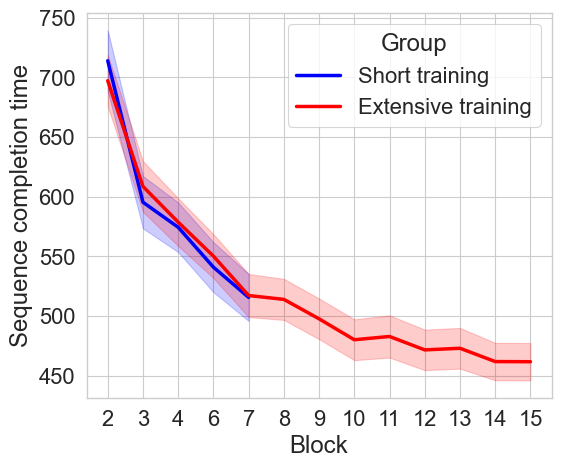

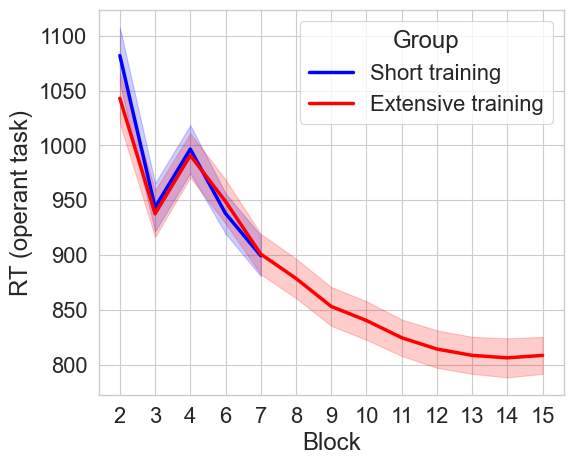

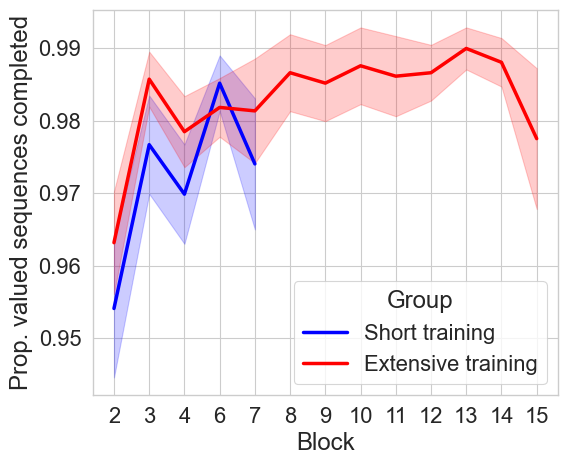

In [215]:
plotTimeVarGroups(main_data_df, var_of_interest='SRO_seq_completion_time', time_var = 'block', var_of_comparison = None, include_never_valued=False, hue_order=['still_valued', 'devalued'], pallette={'short': 'blue', 'more_extensive': 'red'}, y_label = 'Sequence completion time', include_test_pahse=False)
plotTimeVarGroups(main_data_df, var_of_interest='SRO_rt_of_SRO_key', time_var = 'block', var_of_comparison = None, include_never_valued=False, hue_order=['still_valued', 'devalued'], pallette={'short': 'blue', 'more_extensive': 'red'}, y_label = 'RT (operant task)', include_test_pahse=False)
plotTimeVarGroups(main_data_df, var_of_interest='sequenceCompleted', time_var = 'block', var_of_comparison = None, include_never_valued=False, hue_order=['still_valued', 'devalued'], pallette={'short': 'blue', 'more_extensive': 'red'}, y_label = 'Prop. valued sequences completed', include_test_pahse=False)

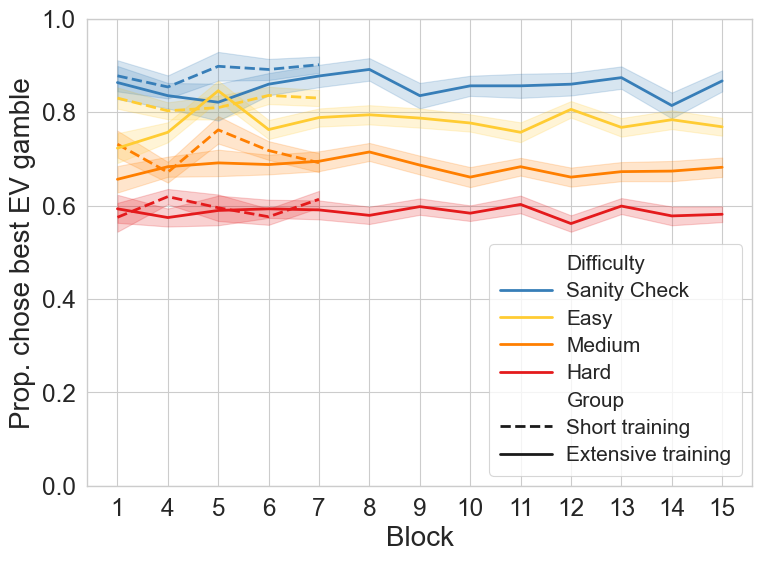

In [216]:
# Filter the data to only include pre_test phase and remove blocks 2 and 3 (SRO only blocks)
rg_filtered = gambles[(gambles['phase'] != 'test') & (gambles['phase'] != 'reacquisition')].copy()
regular_gambles_summary = (
    rg_filtered.groupby(['group', 'sub', 'block', 'gamble_type'])['chose_best_EV']
    .mean()
    .reset_index()
)

# Set a larger font size for plotting (for a paper)
sns.set_context("paper", font_scale=2)

# Custom palette with updated colors
difficulty_palette = {
    'sanityCheck': '#377eb8',   # Blue
    'easy': '#ffcc33',          # Yellow-Orange
    'medium': '#ff7f00',        # Orange
    'hard': '#e41a1c'           # Red
}

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# Get all unique blocks in sorted order
all_blocks = sorted(set(regular_gambles_summary['block']))

# Convert block to string
regular_gambles_summary['block'] = regular_gambles_summary['block'].astype(str)
block_order = sorted(regular_gambles_summary['block'].unique(), key=int)

short_gambles = regular_gambles_summary[regular_gambles_summary.group == 'short']
more_extensive_gambles = regular_gambles_summary[regular_gambles_summary.group == 'more_extensive']

sns.lineplot(
    data=short_gambles,
    x='block',
    y='chose_best_EV',
    hue='gamble_type',
    hue_order=['sanityCheck', 'easy', 'medium', 'hard'],
    ax=ax,
    errorbar=('se', 1),
    palette=difficulty_palette,
    legend=False,
    linewidth=2,
    linestyle='--'
)
sns.lineplot(
    data=more_extensive_gambles,
    x='block',
    y='chose_best_EV',
    hue='gamble_type',
    hue_order=['sanityCheck', 'easy', 'medium', 'hard'],
    ax=ax,
    errorbar=('se', 1),
    palette=difficulty_palette,
    legend=False,
    linewidth=2,
    linestyle='-'
)

ax.set_xticks(block_order)
ax.set_xticklabels(block_order)

ax.set_xlabel('Block', fontsize=20)
ax.set_ylabel('Prop. chose best EV gamble', fontsize=20)
ax.set(ylim=(0, 1))


difficulty_handles = [
    Line2D([0], [0], color=difficulty_palette['sanityCheck'], lw=2, label='Sanity Check'),
    Line2D([0], [0], color=difficulty_palette['easy'], lw=2, label='Easy'),
    Line2D([0], [0], color=difficulty_palette['medium'], lw=2, label='Medium'),
    Line2D([0], [0], color=difficulty_palette['hard'], lw=2, label='Hard'),
]

# Define handles for group (line style)
group_handles = [
    Line2D([0], [0], color='k', lw=2, linestyle='--', label='Short training'),
    Line2D([0], [0], color='k', lw=2, linestyle='-', label='Extensive training'),
]

# Combine with section titles (as dummy handles)
legend_handles = [
    Line2D([0], [0], color='w', label='Difficulty', linewidth=0),  # Section title
    *difficulty_handles,
    Line2D([0], [0], color='w', label='Group', linewidth=0),       # Section title
    *group_handles
]

# Create the legend
ax.legend(
    handles=legend_handles,
    loc='lower right',
    frameon=True,
    fontsize=15,
    title_fontsize=15,
    handlelength=2.5,
    borderpad=0.5,         
    handletextpad=0.7,    
    labelspacing=0.4,     
    borderaxespad=0.5    
)
plt.tight_layout()
plt.show()


## ==========================================
## Effects of trainig duration on outcome devaluation + consumption test (Figs 2 & S2)
## ==========================================


### Consumption test

In [217]:
CT_data
plot_df = CT_data.copy()
plot_df.loc[plot_df.manipulation.isna(),'manipulation'] = 'Before'
plot_df.loc[plot_df.manipulation=='devaluation','manipulation'] = 'After'
plot_df.rename(columns={'manipulation': 'Devaluation'}, inplace=True)

# For each subject, get their manipulation_stim from the 'After' row
stim_map = plot_df[plot_df['Devaluation'] == 'After'].set_index('sub')['manipulation_stim'].to_dict()
plot_df['manipulation_stim'] = plot_df.apply(
    lambda row: stim_map.get(row['sub']) if pd.isna(row['manipulation_stim']) else row['manipulation_stim'],
    axis=1
)
# create a new column called devalued where it takes the value under the column blue or red according to manipulation_stim:
plot_df['Devalued'] = plot_df.apply(
    lambda row: row['blue'] if row['manipulation_stim'] == 'blue' else row['red'] if row['manipulation_stim'] == 'red' else None,
    axis=1
)
plot_df['Valued'] = plot_df.apply(
    lambda row: row['red'] if row['manipulation_stim'] == 'blue' else row['blue'] if row['manipulation_stim'] == 'red' else None,
    axis=1
)

plot_df = plot_df[['sub', 'group', 'Devaluation', 'Devalued', 'Valued']].copy()

# Have Devalued and Valued as combined to one column with them as a condition column:
plot_df = pd.melt(plot_df, id_vars=['sub', 'group', 'Devaluation'], 
                  value_vars=['Devalued', 'Valued'],
                  var_name='Condition', value_name='Gems_collected')

plot_df['Devaluation'] = pd.Categorical(plot_df['Devaluation'], categories=['Before', 'After'], ordered=True)
plot_df['Condition'] = pd.Categorical(plot_df['Condition'], categories=['Valued', 'Devalued'], ordered=True)
plot_df.sort_values(by=['sub', 'Devaluation', 'Condition'], inplace=True)
plot_df.reset_index(drop=True, inplace=True)


#### Fig. S2A

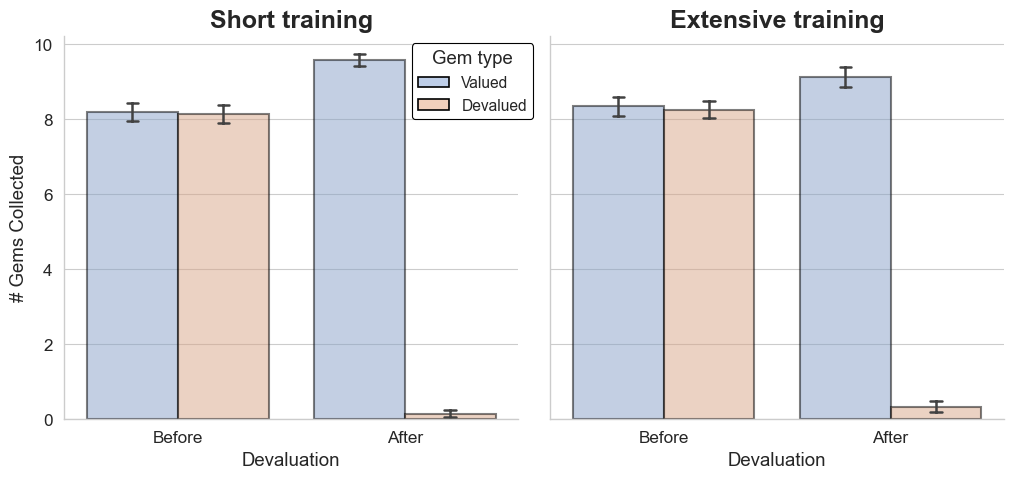

In [218]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.4)

# Define fill colors (with alpha applied in patch manually)
fill_palette = {
    'Valued': 'green',
    'Devalued': 'red',
}
fill_palette = {
    'Valued': '#7e9ed2',
    'Devalued': '#e6a37a'
}


alpha = 0.5  # for consistent transparency

# Create the grouped bar plot
g = sns.catplot(
    data=plot_df,
    x='Devaluation',
    y='Gems_collected',
    hue='Condition',
    col='group',
    kind='bar',
    palette=fill_palette,
    errorbar='se',
    alpha=alpha,
    height=5,
    aspect=0.9,
    sharey=True,
    capsize=0.1

)

g.set_axis_labels("Devaluation", "# Gems Collected")
title_map = {
    'Short training': 'Short training',
    'Extensive training': 'Extensive training'
}
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title_map.get(title, title), weight='bold')

for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            bar.set_edgecolor("black")
            bar.set_linewidth(1.5)
            # Ensure facecolor alpha remains consistent
            fc = bar.get_facecolor()
            bar.set_facecolor((fc[0], fc[1], fc[2], alpha))

g._legend.remove()

# Custom legend with alpha and black edges
handles = [
    mpatches.Patch(
        facecolor=(*sns.color_palette([fill_palette['Valued']])[0], alpha),  # RGBA for red
        # facecolor=(0.545, 0.757, 0.486, 0.6),  # RGBA for green
        edgecolor='black',
        label='Valued',
        linewidth=1.2
    ),
    mpatches.Patch(
        facecolor=(*sns.color_palette([fill_palette['Devalued']])[0], alpha),  # RGBA for green
        # facecolor=(0.945, 0.486, 0.486, 0.6),  # RGBA for red
        edgecolor='black',
        label='Devalued',
        linewidth=1.2
    )
]

# Add new legend to top-right of left subplot
g.axes[0][0].legend(
    handles=handles,
    title="Gem type",
    loc='upper right',
    bbox_to_anchor=(1.05, 1),  # x=1.25 pushes it to the right
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize='small',         # reduce legend text
    title_fontsize='medium'   # adjust title size
)

# Rename facet titles
title_map = {
    'short': 'Short training',
    'more_extensive': 'Extensive training'
}

for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title_map.get(title, title), weight='bold', fontsize=18)

plt.tight_layout()
plt.show()


#### Fig. 2E

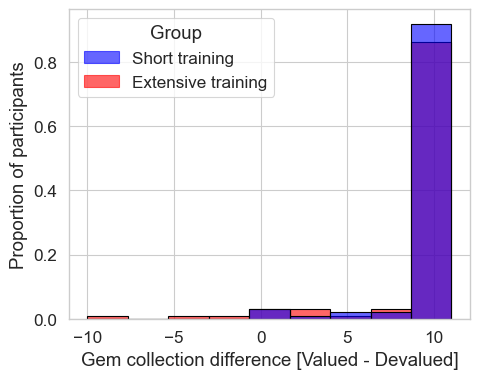

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Transparency level used in the bars
alpha_val = 0.6

group_palette = {
    'short': 'blue',
    'more_extensive': 'red'
}

# Manual legend handles with alpha applied
handles = [
    mpatches.Patch(color='blue', alpha=alpha_val, label='Short training'),
    mpatches.Patch(color='red', alpha=alpha_val, label='Extensive training')
]

# Plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.4)

ax = sns.histplot(
    data=CT_data,
    hue='group',
    x='non_manip_minus_manip',
    palette=group_palette,
    stat='probability',
    common_norm=False,
    multiple='layer',
    alpha=alpha_val,
    edgecolor='black'
)

ax.set_xlabel('Gem collection difference [Valued - Devalued]')
ax.set_ylabel('Proportion of participants')
ax.legend(handles=handles, title='Group')

plt.tight_layout()
plt.show()


In [220]:
CT_data_for_stats = CT_data.copy()
# keep only row with manipulation = devaluation:
CT_data_for_stats = CT_data_for_stats[CT_data_for_stats['manipulation'] == 'devaluation'].reset_index(drop=True)
CT_data_for_stats

,sub,group,block,trial,manipulation_stim,manipulation,blue,red,ice,rock,misses,non_manip_minus_manip
0,1001,short,7,33,red,devaluation,10,0,10,0,0,10.0
1,1002,short,7,33,red,devaluation,10,0,10,0,0,10.0
2,1003,short,7,33,red,devaluation,10,10,0,0,1,0.0
3,1004,short,7,33,blue,devaluation,0,10,10,0,0,10.0
4,1005,short,7,33,red,devaluation,10,0,0,0,0,10.0
5,1006,short,7,33,blue,devaluation,1,10,5,0,0,9.0
6,1007,short,7,33,blue,devaluation,1,10,10,0,0,9.0
7,1008,short,7,33,red,devaluation,10,0,0,0,0,10.0
8,1009,short,7,33,blue,devaluation,0,10,3,0,0,10.0
9,1010,short,7,33,red,devaluation,10,0,2,0,0,10.0


#### stats

In [221]:
%%R -i CT_data_for_stats
library(lme4)
# make group a factor:
CT_data_for_stats$group <- as.factor(CT_data_for_stats$group)
# do effect coding:
contrasts(CT_data_for_stats$group) <- contr.sum(2)

# run lm:
lm_model <- lm(non_manip_minus_manip ~ group, data = CT_data_for_stats)

print(summary(lm_model))

library(sjPlot)
tab_model(lm_model, show.std = TRUE)



Call:
lm(formula = non_manip_minus_manip ~ group, data = CT_data_for_stats)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.8105   0.5612   0.5612   1.1895   2.1895 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.1247     0.2000   45.62   <2e-16 ***
group1       -0.3141     0.2000   -1.57    0.118    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.779 on 191 degrees of freedom
Multiple R-squared:  0.01275,	Adjusted R-squared:  0.007577 
F-statistic: 2.466 on 1 and 191 DF,  p-value: 0.118



### Devaluation Summary - Main (sensitivity to outcome value)

#### Devalued Sequence Completion (Fig. 2A)

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/4217144254.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


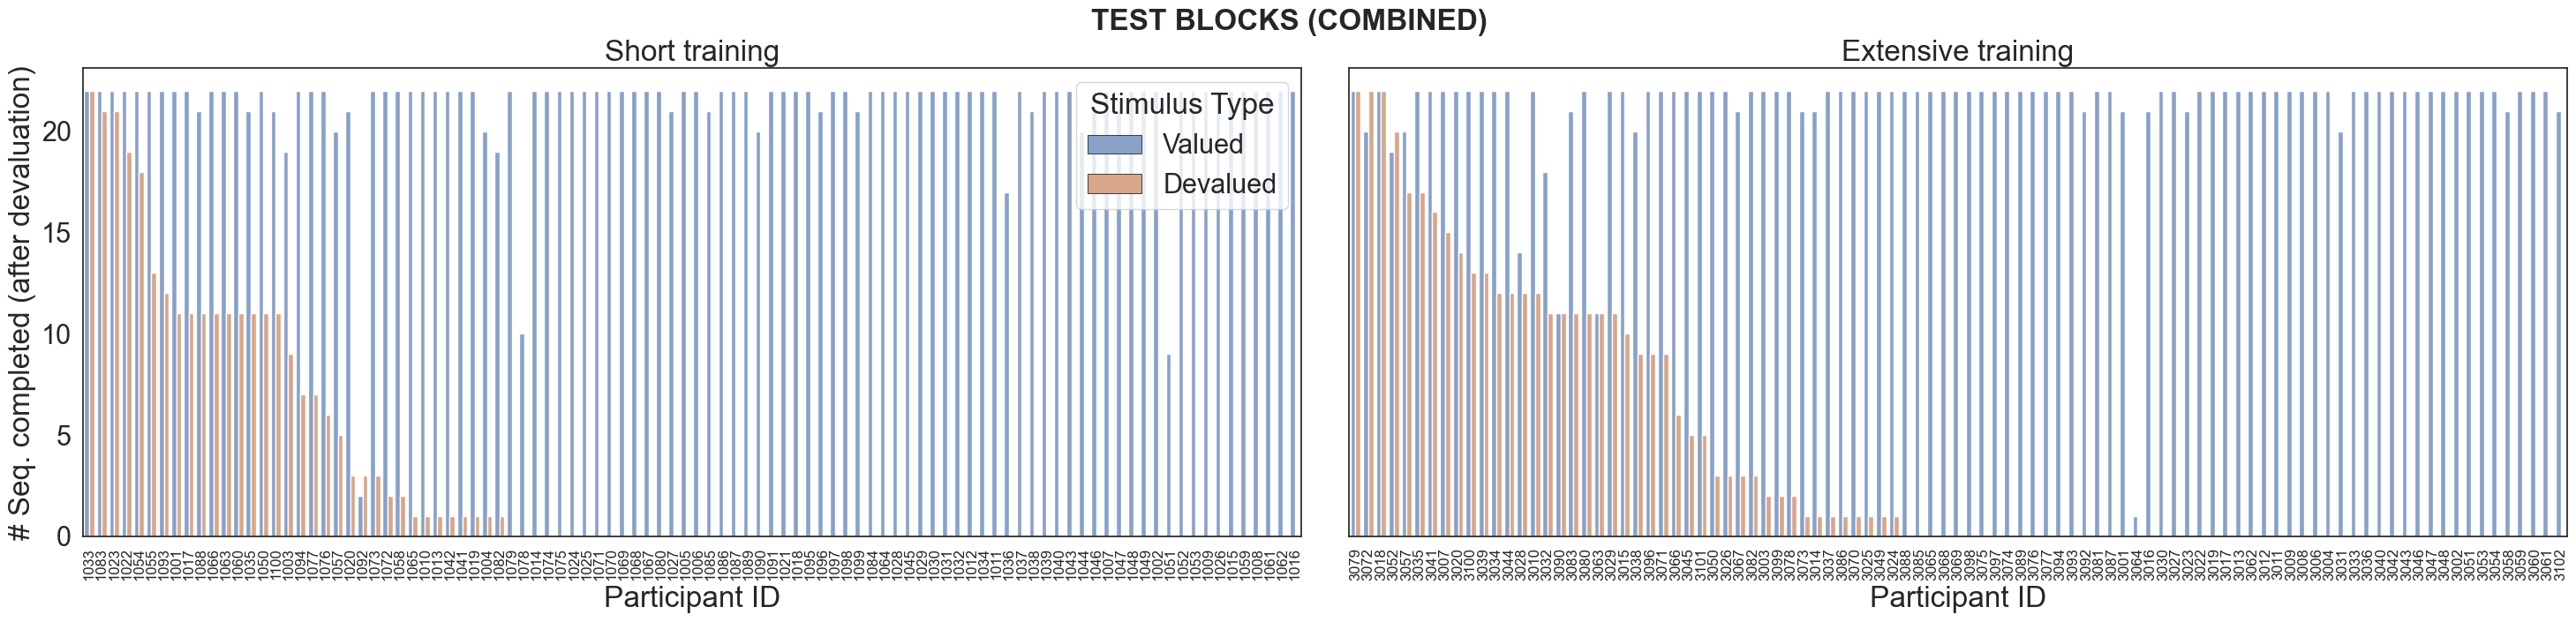

In [222]:
sns.set(font_scale=2)
sns.set_style("white")
# Color palette
fill_palette = {
    'Valued': '#7e9ed2',
    'Devalued': '#e6a37a'
}

# Prepare data
deval_data = main_data_df[main_data_df['phase'].notnull()]
deval_data = deval_data[deval_data['stim_condition'] != 'never_valued']
deval_data['phase'] = deval_data['phase'].astype(str)

deval_data.loc[deval_data['phase'] == 'pre_test','phase'] = 'before'
deval_data.loc[(deval_data['phase'] == 'test') | (deval_data['phase'] == 'reacquisition'),'phase'] = 'after'

# Rename conditions
deval_data['stim_condition'] = deval_data['stim_condition'].replace({
    'still_valued': 'Valued',
    'devalued': 'Devalued'
})

# Summarize
deval_data_summary = deval_data.groupby(['group', 'sub', 'phase', 'stim_condition'])['sequenceCompleted'].sum().reset_index()

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(30, 7.5), sharey=True)

for i, group in enumerate(['short', 'more_extensive']):
    data_to_plot = deval_data_summary[
        (deval_data_summary['phase'] == 'after') &
        (deval_data_summary['group'] == group)
    ]
    order = data_to_plot[data_to_plot['stim_condition'] == 'Devalued'].sort_values(
        by='sequenceCompleted', ascending=False
    )['sub'].unique()

    sns.barplot(
        x='sub',
        y='sequenceCompleted',
        hue='stim_condition',
        hue_order=['Valued', 'Devalued'],
        data=data_to_plot,
        order=order,
        palette=fill_palette,
        ax=axs[i]
    )

    axs[i].set_title('Short training' if group == 'short' else 'Extensive training')
    axs[i].set_ylabel('# Seq. completed (after devaluation)')
    axs[i].set_xlabel('Participant ID')
    
    # Reduce xtick label size and rotate
    axs[i].tick_params(axis='x', labelrotation=90, labelsize=12)
    axs[i].legend_.remove()

legend = axs[0].legend(title='Stimulus Type')

for handle in legend.legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)
    
fig.tight_layout(pad=1.5)
fig.suptitle('TEST BLOCKS (COMBINED)', fontsize=24, weight='bold')

# Show plot
plt.show()



#### Fig. 2C

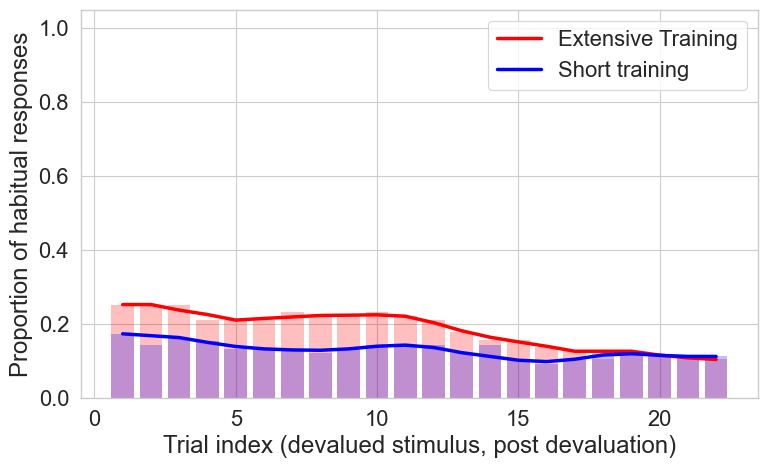

In [223]:
sns.set_theme(style="whitegrid")  # Or "ticks"
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8,
})

label_map = {
    'more_extensive': 'Extensive Training',
    'short': 'Short training'
}
color_map = {
    'Extensive Training': 'red',
    'Short training': 'blue'
}

# Prepare data
only_deval = main_data_df[main_data_df['phase'].notnull()].copy().reset_index(drop=True)
only_deval['phase'] = only_deval['phase'].astype(str)
only_deval.loc[only_deval['phase'] == 'pre_test','time'] = 'before'
only_deval.loc[(only_deval['phase'] == 'test') | (only_deval['phase'] == 'reacquisition'),'time'] = 'after'
only_deval = only_deval[only_deval['time'] == 'after'].copy().reset_index(drop=True)

only_deval = only_deval[only_deval['stim_condition'] == 'devalued'].copy().reset_index(drop=True)

only_deval['abs_devalued_trial'] = only_deval.groupby(['sub']).cumcount() + 1
only_deval['abs_devalued_trial'].unique()

only_deval = only_deval.copy()
only_deval['group_pretty'] = only_deval['group'].map(label_map).fillna(only_deval['group'])

def plot_binary_density_by_group(df, xcol, ycol='sequenceCompleted', groupcol='group_pretty', frac=0.2, title=None):
    plt.figure(figsize=(8, 5))

    line_handles = []

    for g, subdf in df.groupby(groupcol):
        # Per-trial proportion for this group
        prop = subdf.groupby(xcol)[ycol].mean().reset_index().sort_values(xcol)
        x = prop[xcol].values
        y = prop[ycol].values

        plt.bar(
            x, y, width=0.8, alpha=0.25, color=color_map.get(g, None), edgecolor='none'
        )

        # LOWESS smooth line
        sm = lowess(y, x, frac=frac, return_sorted=True)
        line, = plt.plot(
            sm[:, 0], sm[:, 1], lw=2.5, color=color_map.get(g, None)
        )

        # Save a line handle for legend
        line_handles.append((g, line))

    plt.ylim(0, 1.05)
    plt.xlabel('Trial index (devalued stimulus, post devaluation)')
    plt.ylabel('Proportion of habitual responses')
    if title:
        plt.title(title)

    # Legend: lines only, two rows
    handles = [h for _, h in line_handles]
    labels = [g for g, _ in line_handles]
    plt.legend(handles, labels, ncol=1, frameon=True)
    plt.tight_layout()
    plt.show()

plot_binary_density_by_group(
    only_deval, 'abs_devalued_trial',
)


#### Effects of last devaluation trial (Fig. 2D + stats)

In [224]:
main_data_df_deval_in_after_only = main_data_df.loc[:, [
    'sub', 'group', 'block', 'trial', 'choice_rt', 'stim_condition', 'sequenceCompleted',
    'SRO_rt_of_SRO_key', 'SRO_seq_completion_time', 'StayOnKey', 'StayOnLocation',
    'phase', 'time'
]].copy()

# Keep only "after" + devalued trials
main_data_df_deval_in_after_only = main_data_df_deval_in_after_only[
    (main_data_df_deval_in_after_only['time'] == 'after') &
    (main_data_df_deval_in_after_only['stim_condition'] == 'devalued')
].reset_index(drop=True)

# add a variable that indicates whether the sequence was completed on the previous trial
main_data_df_deval_in_after_only['previous_deval_sequenceCompleted'] = (
    main_data_df_deval_in_after_only.groupby(['sub', 'block'])['sequenceCompleted']
    .shift(1)
)
# change 0 to "Not responded" and 1 to "Responded":
main_data_df_deval_in_after_only['previous_deval_sequenceCompleted'] = main_data_df_deval_in_after_only['previous_deval_sequenceCompleted'].replace({0: 'Not responded', 1: 'Responded'})
main_data_df_deval_in_after_only['sequenceCompleted'] = main_data_df_deval_in_after_only['sequenceCompleted'].astype(int)

# Send to R
robjects.globalenv['ME_data'] = pandas2ri.py2rpy(main_data_df_deval_in_after_only)

# --- R side: Fit model and get Approach A predictions ---
r_code = """
library(ggplot2)
library(dplyr)
library(tidyr)
library(viridis)
library(stringr)  # Add this for str_extract

# Run the model with effect coding for significance, but first with the two relevant reference levels for simple effects:

# Factors
ME_data$sub   <- factor(ME_data$sub)
ME_data$group <- factor(ME_data$group, levels = c("short", "more_extensive"))
ME_data$previous_deval_sequenceCompleted <- factor(ME_data$previous_deval_sequenceCompleted, levels = c("Not responded", "Responded"))

# Run with different reference levels:
# ---------------------------------------------
simple_model <- glmer(sequenceCompleted ~ previous_deval_sequenceCompleted * group + (1 | sub), data = ME_data, family = binomial, control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5)))
print("SIMPLE MODEL SUMMARY with Not responded as Ref level:")
print(summary(simple_model))

ME_data$previous_deval_sequenceCompleted <- factor(ME_data$previous_deval_sequenceCompleted, levels = c("Responded", "Not responded"))  # Reverse order for effect coding
# First fit the simple model
simple_model <- glmer(sequenceCompleted ~ previous_deval_sequenceCompleted * group + (1 | sub), data = ME_data, family = binomial, control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5)))
print("SIMPLE MODEL SUMMARY with Responded as Ref level:")
print(summary(simple_model))


# Plot the data:
# -----------------------------
# Remove NA from first trial in each block
ME_data_for_plot <- ME_data %>%
  filter(!is.na(previous_deval_sequenceCompleted)) %>%
  mutate(
    prev_deval_label = ifelse(previous_deval_sequenceCompleted == "Not responded",
                              "Non-habitual response on previous trial",  
                              "Habitual response on previous trial"), 
    subject_id = paste0("Subject ", sub)
  )
# Compute subject-level averages
subject_rates <- ME_data_for_plot %>%
  group_by(sub, group, prev_deval_label, subject_id) %>%
  summarise(
    avg_completion = mean(sequenceCompleted, na.rm = TRUE),
    .groups = "drop"
  )
subject_rates <- subject_rates %>%
  mutate(group = ifelse(group == "short", "Short", "Extensive"))
subject_rates <- subject_rates %>%
  mutate(
    group = factor(group, levels = c("Short", "Extensive"))
  )

# Plot: boxplots + individual subject dots
data_plot <- subject_rates %>%
  ggplot(aes(x = group, y = avg_completion, color = group, fill = group)) +
  geom_boxplot(alpha = 0.2, outlier.shape = NA, width = 0.3) +
  geom_jitter(width = 0.14, height = 0, alpha = 0.3, size = 1.5) +
  facet_wrap(~prev_deval_label) +
  scale_color_manual(values = c("Short" = "blue", "Extensive" = "red")) +
  scale_fill_manual(values = c("Short" = "blue", "Extensive" = "red")) +
  scale_y_continuous(limits = c(0, 1)) +
  labs(
    x = "Training Group",
    y = "Porp. of habitual responses",
    color = "Group",
    fill = "Group"
  ) +
  theme_bw() +
  theme(
    strip.text = element_text(size = 14.5, face = "bold"),
    axis.title.x = element_text(size = 18),   # x-axis title bigger
    axis.title.y = element_text(size = 18),   # y-axis title bigger
    axis.text = element_text(size = 16),
    legend.position = "none"
  )

print(data_plot)

ggsave("PLOT_Observed_completion_boxpoints_STUDY1.png", data_plot,
       width = 9, height = 6, dpi = 300)
       

# Now run the model with effect coding:
contrasts(ME_data$group) <- contr.sum(2)
contrasts(ME_data$previous_deval_sequenceCompleted) <- contr.sum(2)

simple_model <- glmer(sequenceCompleted ~ previous_deval_sequenceCompleted * group + (1 | sub), data = ME_data, family = binomial, control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5)))
print("SIMPLE MODEL SUMMARY with effect coding:")
print(summary(simple_model))
library(car)
print(Anova(simple_model, type = "III"))  # Type III ANOVA for significance testing

"""
robjects.r(r_code)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "previous_deval_sequenceCompleted". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


[1] "SIMPLE MODEL SUMMARY with Not responded as Ref level:"
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequenceCompleted ~ previous_deval_sequenceCompleted * group +  
    (1 | sub)
   Data: ME_data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  1114.4   1145.7   -552.2   1104.4     3855 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1927 -0.1040 -0.0779 -0.0779 14.0845 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 2.399    1.549   
Number of obs: 3860, groups:  sub, 193

Fixed effects:
                                                              Estimate
(Intercept)                                                    -4.8138
previous_deval_sequenceCompletedResponded                       5.5076
groupmore_extensive                                             0.8008
previous_

In [225]:
# getting ORs:
print(np.exp(0.8008))
print(np.exp(-0.2227))

2.2273220735983092
0.8003549197581116


#### Sequences completed before and after outcome devluation + Effects training duration
#### Fig. 2B

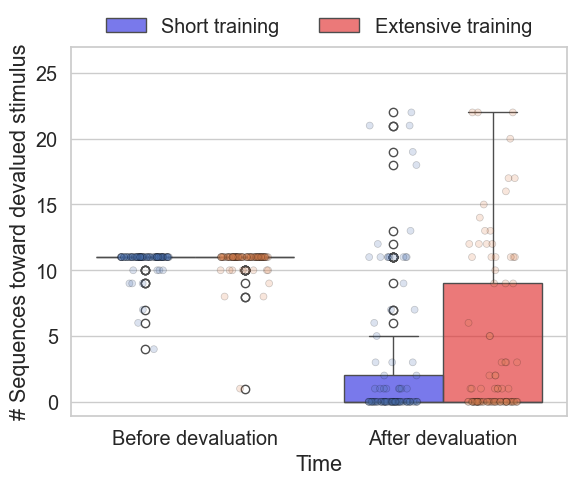

In [226]:
# create a violin plot of the data:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

# a boxplot with stripplot:
# -------------------------------------------
ax= sns.boxplot(data=deval_data_summary[(deval_data_summary['stim_condition'] == 'Devalued')], x='phase', y='sequenceCompleted', order=['before', 'after'], hue='group', hue_order=['short', 'more_extensive'], palette={'short': 'blue', 'more_extensive': 'red'})

plt.xticks([0, 1], ['Before devaluation', 'After devaluation'])

# set y label:
plt.ylabel('# Sequences toward devalued stimulus')
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

sns.stripplot(data=deval_data_summary[(deval_data_summary['stim_condition'] == 'Devalued')], x='phase', y='sequenceCompleted', order=['before', 'after'], hue='group', hue_order=['short', 'more_extensive'], dodge=True, jitter=0.2, alpha=0.2, edgecolor='black', linewidth=0.5)

# place legend outside the figure/plot
plt.xlabel('Time')

# Get the current handles and labels
handles, labels = ax.get_legend_handles_labels()

# Remove the last two labels
handles = handles[:-2]
labels = labels[:-2]

# Create the legend with two columns, above the plot, no frame
legend = plt.legend(
    handles, labels,
    loc='lower center',         
    bbox_to_anchor=(0.5, .98), 
    ncol=2,                     
    frameon=False              
)

# Update labels as before
new_labels = ['Short training', 'Extensive training']
for t, l in zip(legend.texts, new_labels):
    t.set_text(l)

plt.ylim(top=27)
plt.show()



In [227]:
# get back to what I had (to have aligned variable names etc.):
deval_data = main_data_df[main_data_df['phase'].notnull()]
deval_data = deval_data[deval_data['stim_condition'] != 'never_valued']
deval_data['phase'] = deval_data['phase'].astype(str)

deval_data.loc[deval_data['phase'] == 'pre_test','time'] = 'before'
deval_data.loc[(deval_data['phase'] == 'test') | (deval_data['phase'] == 'reacquisition'),'time'] = 'after'

deval_data_summary = deval_data.groupby(['group', 'sub', 'time', 'phase', 'stim_condition'])['sequenceCompleted'].sum().reset_index()
deval_data_summary = deval_data_summary.reset_index()


#### Logistic Regression + robustness checks!

Main:

In [228]:
deval_data_for_logistic = main_data_df[main_data_df['phase'].notnull()].reset_index(drop=True)

ME_data = deval_data_for_logistic.copy().reset_index(drop=True)
ME_data = deval_data_for_logistic[(deval_data_for_logistic['stim_condition'] != 'never_valued')].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'sequenceCompleted']]

ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after')

# Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """
library(lme4)
library(lmerTest)
library(car)

ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "devalued")
ME_data$sequenceCompleted <- as.factor(ME_data$sequenceCompleted)

# Now effect coding for all (-1 and 1)
contrasts(ME_data$group) <- contr.sum(2)  # sum-to-zero contrasts
contrasts(ME_data$time) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
model <- glmer(sequenceCompleted ~ group * time * stim_condition + (1| sub), data = ME_data, family = binomial(link = "logit"), control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000)))
print(summary(model))
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequenceCompleted ~ group * time * stim_condition + (1 | sub)
   Data: ME_data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
  4220.1   4287.2  -2101.1   4202.1    12728 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-69.900  -0.145   0.076   0.130  57.557 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 4.326    2.08    
Number of obs: 12737, groups:  sub, 193

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   3.13429    0.17066  18.366  < 2e-16 ***
group1                        0.10339    0.16937   0.610  0.54155    
time1                         2.13254    0.07261  29.372  < 2e-16 ***
stim_condition1              -1.89429    0.07106 -26.658  < 2e-16 ***
group1:time1       

#### Each test block separately
(to test if the effect was mainly driven by a single test block):

In [229]:
 # NOTE: When testing only test phase, and when testing only reacquisition phase, result pattern is similar.
deval_data_for_logistic = main_data_df[main_data_df['phase'].notnull()].reset_index(drop=True)

ME_data = deval_data_for_logistic.copy().reset_index(drop=True)
ME_data = deval_data_for_logistic[(deval_data_for_logistic['stim_condition'] != 'never_valued')].reset_index(drop=True)
# remove 2nd test block phase ('reacquisition' phase):
ME_data = ME_data[ME_data['phase'] != 'reacquisition'].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'sequenceCompleted']]

ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """
library(lme4)
library(lmerTest)
library(car)
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
ME_data$sequenceCompleted <- as.factor(ME_data$sequenceCompleted)

# logistic mixed effects model:
contrasts(ME_data$group) <- contr.sum(2)  # sum-to-zero contrasts
contrasts(ME_data$time) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
model <- glmer(sequenceCompleted ~ group * time * stim_condition + (1| sub), data = ME_data, family = binomial(link = "logit"), control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000)))
# Type III ANOVA
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)

# --------------------------------------------------------

deval_data_for_logistic = main_data_df[main_data_df['phase'].notnull()].reset_index(drop=True)

ME_data = deval_data_for_logistic.copy().reset_index(drop=True)
ME_data = deval_data_for_logistic[(deval_data_for_logistic['stim_condition'] != 'never_valued')].reset_index(drop=True)
# remove 1st block test phase:
ME_data = ME_data[ME_data['phase'] != 'test'].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'sequenceCompleted']]

ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """
library(lme4)
library(lmerTest)
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
ME_data$sequenceCompleted <- as.factor(ME_data$sequenceCompleted)

# logistic mixed effects model:
contrasts(ME_data$group) <- contr.sum(2)  # sum-to-zero contrasts
contrasts(ME_data$time) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
model <- glmer(sequenceCompleted ~ group * time * stim_condition + (1| sub), data = ME_data, family = binomial(link = "logit"), control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000)))
# Type III ANOVA
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)


Analysis of Deviance Table (Type III Wald chisquare tests)

Response: sequenceCompleted
                             Chisq Df Pr(>Chisq)    
(Intercept)               235.1817  1  < 2.2e-16 ***
group                       0.3517  1   0.553143    
time                      630.6120  1  < 2.2e-16 ***
stim_condition            494.7999  1  < 2.2e-16 ***
group:time                  3.7006  1   0.054393 .  
group:stim_condition        2.5780  1   0.108356    
time:stim_condition       487.2628  1  < 2.2e-16 ***
group:time:stim_condition   8.7883  1   0.003032 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
None
Analysis of Deviance Table (Type III Wald chisquare tests)

Response: sequenceCompleted
                             Chisq Df Pr(>Chisq)    
(Intercept)               227.7329  1  < 2.2e-16 ***
group                       0.0282  1   0.866661    
time                      549.9783  1  < 2.2e-16 ***
stim_condition            509.2825  1  < 2.2e-16 ***
group:time

#### Now with exclusion according to the CT task

In [230]:
deval_data_for_logistic = main_data_df[main_data_df['phase'].notnull()].reset_index(drop=True)

ME_data = deval_data_for_logistic.copy().reset_index(drop=True)
ME_data = deval_data_for_logistic[(deval_data_for_logistic['stim_condition'] != 'never_valued')].reset_index(drop=True)
ME_data = ME_data[ME_data['sub'].isin(CT_data[CT_data['non_manip_minus_manip'] <= 5]['sub'].unique()) == False]
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'sequenceCompleted']]

ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# # Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """
library(lme4)
library(lmerTest)
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
ME_data$sequenceCompleted <- as.factor(ME_data$sequenceCompleted)

# logistic mixed effects model:
contrasts(ME_data$group) <- contr.sum(2)  # sum-to-zero contrasts
contrasts(ME_data$time) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
model <- glmer(sequenceCompleted ~ group * time * stim_condition + (1| sub), data = ME_data, family = binomial(link = "logit"), control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000)))
print(summary(model))
# Type III ANOVA
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequenceCompleted ~ group * time * stim_condition + (1 | sub)
   Data: ME_data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
  3214.8   3281.1  -1598.4   3196.8    11672 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-95.373  -0.102   0.050   0.095  21.072 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 5.036    2.244   
Number of obs: 11681, groups:  sub, 177

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   3.356975   0.195865  17.139   <2e-16 ***
group1                       -0.007335   0.193253  -0.038   0.9697    
time1                         2.231462   0.085836  25.997   <2e-16 ***
stim_condition1               2.238807   0.085900  26.063   <2e-16 ***
group1:time1  

#### Now controlling for the CT task measure

In [231]:
CT_data_test = CT_data.loc[~CT_data.manipulation_stim.isnull()]
CT_data_test = CT_data_test[['sub', 'non_manip_minus_manip']]
# normalize the non_manip_minus_manip scores:
CT_data_test['non_manip_minus_manip'] = (CT_data_test['non_manip_minus_manip'] - CT_data_test['non_manip_minus_manip'].mean()) / CT_data_test['non_manip_minus_manip'].std()

deval_data_for_logistic = main_data_df[main_data_df['phase'].notnull()].reset_index(drop=True)
deval_data_for_logistic = pd.merge(deval_data_for_logistic, CT_data_test, on='sub', how='outer')

ME_data = deval_data_for_logistic[(deval_data_for_logistic['stim_condition'] != 'never_valued')].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'non_manip_minus_manip', 'sequenceCompleted']]
ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# # Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """

library(lme4)
library(lmerTest)
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
ME_data$sequenceCompleted <- as.factor(ME_data$sequenceCompleted)

# logistic mixed effects model:
contrasts(ME_data$group) <- contr.sum(2)  # sum-to-zero contrasts
contrasts(ME_data$time) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
model <- glmer(sequenceCompleted ~ group * time * stim_condition + non_manip_minus_manip + (1| sub), data = ME_data, family = binomial(link = "logit"), control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000)))
print(summary(model))
# Type III ANOVA
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
sequenceCompleted ~ group * time * stim_condition + non_manip_minus_manip +  
    (1 | sub)
   Data: ME_data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
  4218.2   4292.7  -2099.1   4198.2    12727 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-73.022  -0.144   0.077   0.130  56.091 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 4.223    2.055   
Number of obs: 12737, groups:  sub, 193

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   3.12937    0.16906  18.510  < 2e-16 ***
group1                        0.13245    0.16846   0.786  0.43175    
time1                         2.12978    0.07250  29.376  < 2e-16 ***
stim_condition1               1.89185    0.07096  26.662  

#### Controlling also with interactions with CT

In [232]:
CT_data_test = CT_data.loc[~CT_data.manipulation_stim.isnull()]
CT_data_test = CT_data_test[['sub', 'non_manip_minus_manip']]
# now normalize the non_manip_minus_manip scores:
CT_data_test['non_manip_minus_manip'] = (CT_data_test['non_manip_minus_manip'] - CT_data_test['non_manip_minus_manip'].mean()) / CT_data_test['non_manip_minus_manip'].std()

deval_data_for_logistic = main_data_df[main_data_df['phase'].notnull()].reset_index(drop=True)
deval_data_for_logistic = pd.merge(deval_data_for_logistic, CT_data_test, on='sub', how='outer')

ME_data = deval_data_for_logistic[(deval_data_for_logistic['stim_condition'] != 'never_valued')].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'non_manip_minus_manip', 'sequenceCompleted']]
ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """

library(lme4)
library(lmerTest)
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
ME_data$sequenceCompleted <- as.factor(ME_data$sequenceCompleted)

# logistic mixed effects model:
contrasts(ME_data$group) <- contr.sum(2)  # sum-to-zero contrasts
contrasts(ME_data$time) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
model <- glmer(sequenceCompleted ~ group * time * stim_condition * non_manip_minus_manip + (1| sub), data = ME_data, family = binomial(link = "logit"), control = glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=100000)))
print(summary(model))
# Type III ANOVA
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
sequenceCompleted ~ group * time * stim_condition * non_manip_minus_manip +  
    (1 | sub)
   Data: ME_data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

     AIC      BIC   logLik deviance df.resid 
  3942.4   4069.0  -1954.2   3908.4    12720 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-98.146  -0.116   0.064   0.108  20.912 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 4.8      2.191   
Number of obs: 12737, groups:  sub, 193

Fixed effects:
                                                   Estimate Std. Error z value
(Intercept)                                         3.28288    0.18279  17.960
group1                                              0.05939    0.18077   0.329
time1                                               2.16892    0.07850  27.630
stim_condition1       

R[write to console]: 
Correlation matrix not shown by default, as p = 16 > 12.
Use print(summary(model), correlation=TRUE)  or
    vcov(summary(model))        if you need it




Analysis of Deviance Table (Type III Wald chisquare tests)

Response: sequenceCompleted
                                                   Chisq Df Pr(>Chisq)    
(Intercept)                                     322.5485  1  < 2.2e-16 ***
group                                             0.1080  1   0.742488    
time                                            763.4333  1  < 2.2e-16 ***
stim_condition                                  696.0237  1  < 2.2e-16 ***
non_manip_minus_manip                             0.2008  1   0.654076    
group:time                                        3.0690  1   0.079798 .  
group:stim_condition                              2.1186  1   0.145518    
time:stim_condition                             683.9690  1  < 2.2e-16 ***
group:non_manip_minus_manip                       0.0033  1   0.954253    
time:non_manip_minus_manip                        0.8835  1   0.347235    
stim_condition:non_manip_minus_manip             42.6357  1  6.594e-11 ***
group:time:s

## ==========================================
## Automaticity and habit relationship (Fig. 3)
## ==========================================

### IPI Consistency (Fig 3A)

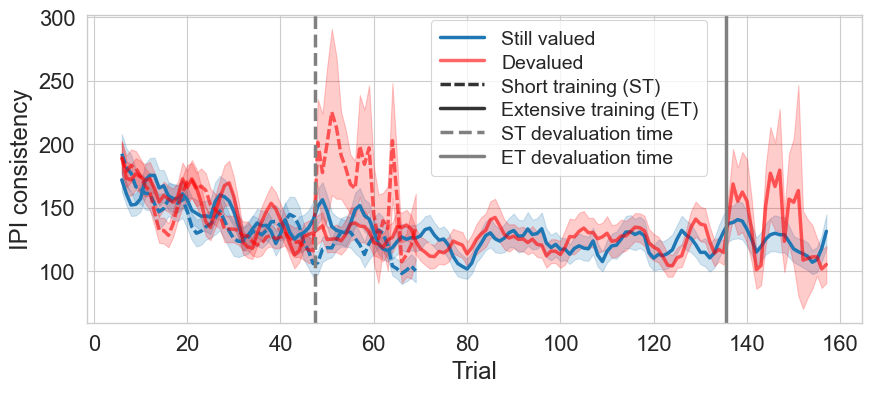

In [233]:
def plotIPIsConsistency(data, var_of_comparison= None, to_smooth=False, smoothing_window=5, combine_groups=False):
    # remove reward type rock:
    data = data[data['rewardType'] != 'rock']

    # -----------------------------------------------------------
    # Prepare the data for plotting:
    # -----------------------------------------------------------
    short_data = data[data['group'] == 'short'].copy()
    more_extensive_data = data[data['group'] == 'more_extensive'].copy()
    # get first trial of devaluation (and reduce 0.5 so the vertical line is between the relevant trials):
    short_first_deval_trial = short_data[short_data['activeManipulation'] == 'devaluation'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5
    more_extensive_first_deval_trial = more_extensive_data[more_extensive_data['activeManipulation'] == 'devaluation'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5

    # smooth the data:
    if to_smooth:
        short_data['IPI_abs_diff_sum'] = (
            short_data.groupby(['sub', 'stim_condition'])['IPI_abs_diff_sum']
            .transform(lambda x: x.rolling(smoothing_window).mean())
        )
        more_extensive_data['IPI_abs_diff_sum'] = (
            more_extensive_data.groupby(['sub', 'stim_condition'])['IPI_abs_diff_sum']
            .transform(lambda x: x.rolling(smoothing_window).mean())
        )

    # -----------------------------------------------------------
    # plot the IPI data:
    # -----------------------------------------------------------
    if var_of_comparison:
        palette=['#1f77b4', (1, 0, 0, 0.6)]
    else:
        palette=None

    if not combine_groups:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        sns.lineplot(data=short_data, x='stim_abs_trial', y='IPI_abs_diff_sum', hue= var_of_comparison, markers=True, palette=palette, ax=axes[0], errorbar=('se',1))

        # plot the devaluation line and mention the line in the legend:
        axes[0].axvline(short_first_deval_trial, color='black', linestyle='--', label='devaluation')
        axes[0].legend()

        # plot more_extensive trainig plots:
        # -----------------------------
        sns.lineplot(data=more_extensive_data, x='stim_abs_trial', y='IPI_abs_diff_sum', hue=var_of_comparison, markers=True, palette=palette, ax=axes[1], errorbar=('se',1))

        # plot the devaluation line and mention the line in the legend:
        axes[1].axvline(more_extensive_first_deval_trial, color='black', linestyle='--', label='devaluation')
        axes[1].legend()

        # title for the figure:
        if var_of_comparison:
            title = 'IPIs consistency by ' + var_of_comparison
        else:
            title = 'IPIs consistency across all stimuli'

        if to_smooth:
            title += f" (rolling average = {smoothing_window})"
            
        fig.suptitle(title, fontsize=16)

        axes[0].set_title('Short training')
        axes[1].set_title('More extensive training')

        axes[0].set_ylim(bottom=min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), top=max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))
        axes[1].set_ylim(bottom=min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), top=max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))
        
        fig.tight_layout()
    else:
        # put back together the short and more extensive data (re-concatenate them):
        reconcat_data = pd.concat([short_data, more_extensive_data])

        fig, axe = plt.subplots(1, 1, figsize=(10, 4))

        sns.lineplot(data=reconcat_data, x='stim_abs_trial', y='IPI_abs_diff_sum', hue= var_of_comparison, style='group', palette=palette, ax=axe, errorbar=('se',1), dashes={'short': (3, 1), 'more_extensive': ''})

        # plot the devaluation line and mention the line in the legend:
        axe.axvline(short_first_deval_trial, color='gray',  label='ST devaluation', linestyle='--')
        # put legend outside the plot:
        axe.axvline(more_extensive_first_deval_trial, color='gray', label='ET devaluation', linestyle='-')

        # title for the figure:
        if var_of_comparison:
            title = 'IPIs consistency by ' + var_of_comparison
        else:
            title = 'IPIs consistency across all stimuli'

        if to_smooth:
            title += f" (rolling average = {smoothing_window})"
            
        axe.set_xlabel('Trial')
        axe.set_ylabel('IPI consistency')
        # Remove Seaborn's automatic legend that includes titles
        if axe.legend_:
            axe.legend_.remove()

        # Get all handles and labels from the current plot
        handles, labels = axe.get_legend_handles_labels()

        # Create a new flat legend without a title
        custom_labels = {
            'still_valued': 'Still valued',
            'devalued': 'Devalued',
            'short': 'Short training (ST)',
            'more_extensive': 'Extensive training (ET)',
            'ST devaluation': 'ST devaluation time',
            'ET devaluation': 'ET devaluation time'
        }

        # Match labels with custom ones, ignore empty or redundant ones
        unique = []
        used = set()
        for h, l in zip(handles, labels):
            if l not in used and l in custom_labels:
                unique.append((h, custom_labels[l]))
                used.add(l)

        # Unpack and add clean legend without a title
        if unique:
            handles_clean, labels_clean = zip(*unique)
            legend = axe.legend(handles_clean, labels_clean, loc='center left', bbox_to_anchor=(0.43, 0.73), title=None, labelspacing=0.2)
            for text in legend.texts:
                text.set_fontsize(14)

# ----------------------------------------------------------------------------------------------------------------------
# prepare data and plot:
# ----------------------------------------------------------------------------------------------------------------------

IPI_consistency_data_by_trial = IPI_consistency_data_by_trial.sort_values(by=['sub', 'block', 'trial']).reset_index(drop=True)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

plotIPIsConsistency(IPI_consistency_data_by_trial, var_of_comparison='stim_condition', to_smooth=True, smoothing_window=5, combine_groups=True)

### Model training (Fig 3B)

In [234]:
# add time to the data (IPI_consistency_data_by_trial):
IPI_consistency_data_by_trial.loc[:, 'time'] = IPI_consistency_data_by_trial['phase'].apply(lambda x: 'before' if x == 'pre_test' else np.nan)
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'test', 'time'] = 'after'
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'reacquisition', 'time'] = 'after'

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3079693695.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.201


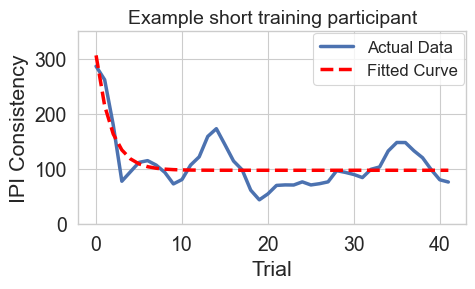

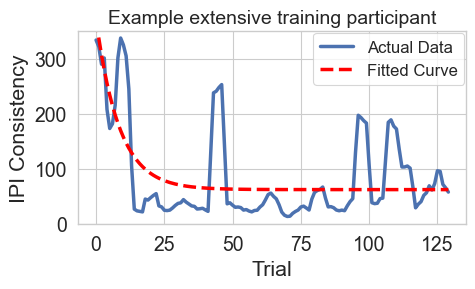

In [235]:
var = 'IPI_abs_diff_sum'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['rewardType'] != 'rock') & (IPI_consistency_data_by_trial['blockType'] != 'gambles_only') & (IPI_consistency_data_by_trial['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    
    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
    if sub == 1060 or sub == 3050:
        df = pd.DataFrame({'x_data': x_data, 'y_data_smoothed': y_data_smoothed, 'stim_condition': data['stim_condition']})
        fig, axes = plt.subplots(1, 1, figsize=(5, 2.5))
        sns.lineplot(x=x_data, y=y_data_smoothed, markers=True, ax=axes, errorbar=('se', 1), data=df, label='Actual Data')
        # plot the fit:
        sns.lineplot(x=x_data, y=y_predicted, ax=axes, color='red', linestyle='--', label='Fitted Curve')
        axes.set_xlabel('Trial')
        axes.set_ylabel('IPI Consistency')
        if sub < 2000:
            axes.set_title(f"Example short training participant", fontsize=14)
        elif sub > 3000:
            axes.set_title(f"Example extensive training participant", fontsize=14)

        # Add legend showing fitted and actual data:
        axes.legend(
            loc='upper right',
            fontsize=12,         # or use a number, e.g., fontsize=8
            # frameon=False,            # optional: removes box around legend
            bbox_to_anchor=(1, 1),    # pin it tightly to the top-right corner
            borderaxespad=0.1         # reduces padding between legend and axes
        )

        axes.set_ylim(0, 350)

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


In [236]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(IPI_consistency_data_by_trial, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')


### Fig 3C

<>:62: DeprecationWarning: invalid escape sequence '\L'
<>:62: DeprecationWarning: invalid escape sequence '\L'
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3389541050.py:62: DeprecationWarning: invalid escape sequence '\L'
  plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')


Pearson correlation for end_of_training_pred with devaluation ratio: 0.282, p-value: 0.0001


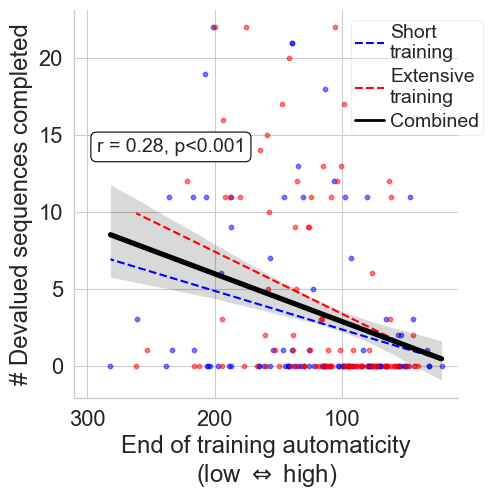

In [237]:



sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'])
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

g = sns.lmplot(
    data=only_after_devalued_data,
    x='end_of_training_pred', y='sequenceCompleted',
    hue='group', hue_order=['short','more_extensive'],
    palette=pallette,
    scatter_kws={'s': 10, 'alpha': 0.5},
    line_kws={'linestyle': '--', 'linewidth': 1.5},  # dashed + thinner line
    order=1,
    ci=None,                # no shaded confidence band
    height=5, aspect=1,
    legend=False
)

# add black line without scatter
sns.regplot(
    data=only_after_devalued_data,
    x='end_of_training_pred', y='sequenceCompleted',
    scatter=False, line_kws={'color': 'black'},
    order=1,
    ax=g.ax
)

plt.ylabel('# Devalued sequences completed')
plt.xlim(right=310)

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], linestyle='--', linewidth=1.5,
           label='Short\ntraining'),
    Line2D([0], [0], color=pallette[1], linestyle='--', linewidth=1.5,
           label='Extensive\ntraining'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=2,
           label='Combined')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.09, 1.0),
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)

plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
plt.annotate(f"r = {pearson_corr:.2f}, p<0.001", xy=(0.058, 0.67), xycoords="axes fraction", fontsize=14, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.gca().invert_xaxis()  # for x-axis


### stats

In [238]:
robjects.globalenv['only_after_devalued_data'] = only_after_devalued_data

r_code = """
library(lme4)
library(lmerTest)
library(car)
library(sjPlot)

only_after_devalued_data$group <- as.factor(only_after_devalued_data$group)
only_after_devalued_data$end_of_training_pred <- scale(only_after_devalued_data$end_of_training_pred)
only_after_devalued_data$sequenceCompleted <- scale(only_after_devalued_data$sequenceCompleted)
# effect coding:
contrasts(only_after_devalued_data$group) <- contr.sum(2)
model <- lm(sequenceCompleted ~ end_of_training_pred*group, data = only_after_devalued_data)
print(summary(model))
print(Anova(model, type = "III"))
tab_model(model, show.std = TRUE)
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)



Call:
lm(formula = sequenceCompleted ~ end_of_training_pred * group, 
    data = only_after_devalued_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6800 -0.5455 -0.3313  0.2149  3.1213 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.004003   0.069006   0.058    0.954    
end_of_training_pred        0.298000   0.070228   4.243 3.45e-05 ***
group1                      0.110214   0.069006   1.597    0.112    
end_of_training_pred:group1 0.069946   0.070228   0.996    0.321    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.958 on 189 degrees of freedom
Multiple R-squared:  0.09655,	Adjusted R-squared:  0.08221 
F-statistic: 6.733 on 3 and 189 DF,  p-value: 0.0002439

Anova Table (Type III tests)

Response: sequenceCompleted
                            Sum Sq  Df F value    Pr(>F)    
(Intercept)                  0.003   1  0.0034    0.9538    
end_of_training_

### Power analysis

Cohen's f^2: 0.09 
Sample size required for 80% power (grid search): 90 
Sample size required for 95% power (grid search): 145 
N for 80% power: 90 
N for 95% power: 147 


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In geom_text(aes(x = n80, y = 0.8, label = paste("N =", n80)), color = "red",  :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 61 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

R[write to console]: 2: 
R[write to console]: In geom_text(aes(x = n95, y = 0.95, label = paste("N =", n95)),  :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 61 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.



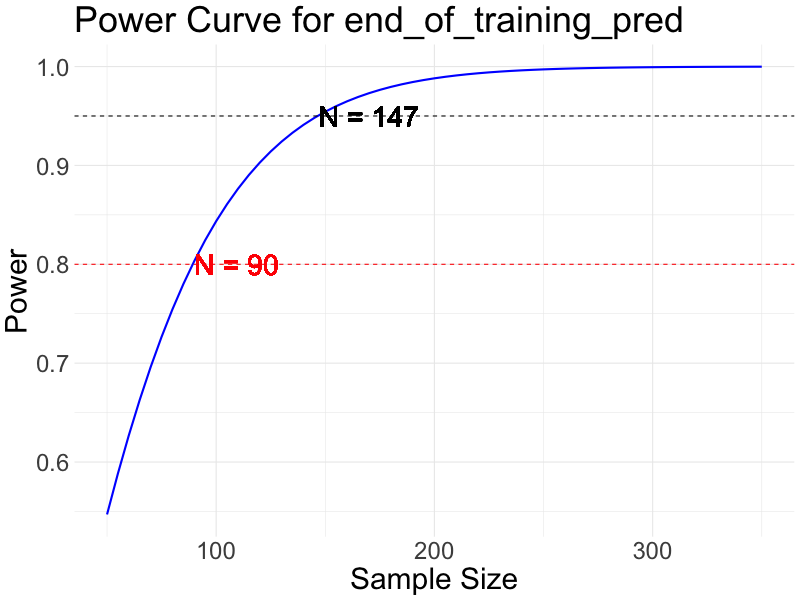

In [239]:
# Import necessary R libraries
grdevices = importr('grDevices')  # For saving plots
robjects.r('library(pwr)')
robjects.r('library(ggplot2)')

# Send data to R
robjects.globalenv['only_after_devalued_data'] = only_after_devalued_data

# Define the R script
r_code = """
# Fit the full model
full_model <- lm(sequenceCompleted ~ end_of_training_pred + group, data = only_after_devalued_data)
r2_full <- summary(full_model)$r.squared

# Fit the reduced model (excluding end_of_training_pred)
reduced_model <- lm(sequenceCompleted ~ group, data = only_after_devalued_data)
r2_reduced <- summary(reduced_model)$r.squared

# Compute Cohen's f^2
f2 <- (r2_full - r2_reduced) / (1 - r2_full)
cat("Cohen's f^2:", round(f2, 3), "\\n")

# Define parameters
alpha <- 0.05
num_predictors <- 1  # Only testing end_of_training_pred
sample_sizes <- seq(50, 350, by = 5)  # Range of sample sizes

# Compute power for each sample size
power_values <- sapply(sample_sizes, function(n) {
  # df_error <- n - length(coef(full_model))  # Residual degrees of freedom
  df_error <- n - 2   # Study 2 model: intercept + end_of_training_pred
  power_test <- pwr.f2.test(u = num_predictors, v = df_error, f2 = f2, sig.level = alpha, power = NULL)
  return(power_test$power)
})

# Create a data frame for plotting
power_df <- data.frame(SampleSize = sample_sizes, Power = power_values)

# Find the required sample size for 80% power
required_n <- sample_sizes[which.min(abs(power_values - 0.80))]
cat("Sample size required for 80% power (grid search):", required_n, "\\n")
# Find the required sample size for 95% power
required_n_95 <- sample_sizes[which.min(abs(power_values - 0.95))]
cat("Sample size required for 95% power (grid search):", required_n_95, "\\n")

# Save the plot as a PNG file
png("PLOT_power_curve.png", width=800, height=600)

# Analytic Ns (nice to report)
n80 <- ceiling(pwr.f2.test(u = 1, f2 = f2, sig.level = alpha, power = 0.80)$v + 2)
n95 <- ceiling(pwr.f2.test(u = 1, f2 = f2, sig.level = alpha, power = 0.95)$v + 2)
cat("N for 80% power:", n80, "\n")
cat("N for 95% power:", n95, "\n")

# Plot power curve
p <- ggplot(power_df, aes(x = SampleSize, y = Power)) +
  geom_line(color = "blue", linewidth = 1) +
  geom_hline(yintercept = 0.80, linetype = "dashed", color = "red") +
  labs(
       title = "Power Curve for end_of_training_pred",
       x = "Sample Size",
       y = "Power") +
  theme_minimal()
p <- p + theme(text = element_text(size=30))
p <- p + geom_hline(yintercept = 0.95, linetype = "dashed", color = "black")
p <- p + geom_text(aes(x = n80, y = 0.8, label = paste("N =", n80)), color = "red", size = 10, hjust = 0)
p <- p + geom_text(aes(x = n95, y = 0.95, label = paste("N =", n95)), color = "black", size = 10, hjust = 0)

# Print and display the plot
print(p)

# Turn off the graphics device (save and close plot)
dev.off()
"""

# Execute the R code


robjects.r(r_code)

# Display the saved plot in Jupyter
img = Image.open("PLOT_power_curve.png")
display(img)



### Habitual and Non-habitual subgroup comparison (Fig 3D)

<>:68: DeprecationWarning: invalid escape sequence '\L'
<>:83: DeprecationWarning: invalid escape sequence '\L'
<>:68: DeprecationWarning: invalid escape sequence '\L'
<>:83: DeprecationWarning: invalid escape sequence '\L'
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3518748825.py:68: DeprecationWarning: invalid escape sequence '\L'
  ax.set_ylabel('End of training automaticity\n(high $\Leftrightarrow$ low)')
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3518748825.py:83: DeprecationWarning: invalid escape sequence '\L'
  ax.set_ylabel('End of training automaticity\n(low $\Leftrightarrow$ high)')


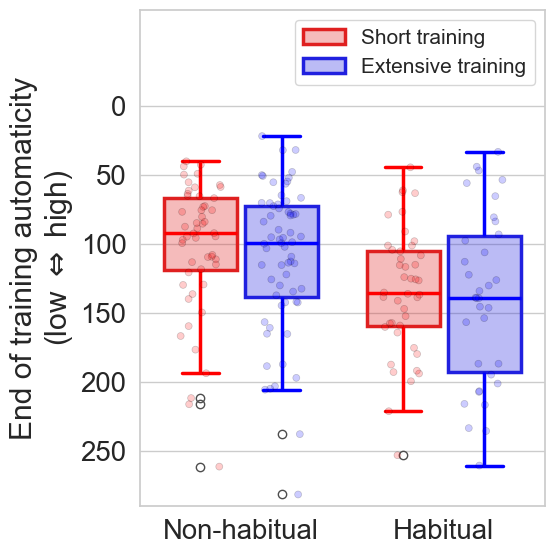

In [240]:
# Set style for paper publication
sns.set(font_scale=1.8)
sns.set_style("whitegrid")

# Define colors and labels
colors = {'short': 'blue', 'more_extensive': 'red'}
new_labels = ['Short training', 'Extensive training']

# Create the habitual column
only_after_devalued_data['isHabitual'] = only_after_devalued_data['sequenceCompleted'].apply(lambda x: 'Habitual' if x > 0 else 'Non-habitual' if x == 0 else np.nan)

# --------------------
# Boxplot with stripplot
# --------------------
fig, ax = plt.subplots(figsize=(6, 6))

# Create boxplot
box_plot = sns.boxplot(
    data=only_after_devalued_data,
    x="isHabitual", 
    y="end_of_training_pred", 
    hue="group",
    palette=colors,
    gap=0.1,
    ax=ax
)

# Make boxes semi-transparent and set line colors/thickness
for i, patch in enumerate(box_plot.patches):
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    # Make box edges thicker and full opacity
    patch.set_edgecolor(patch.get_facecolor()[:3])
    patch.set_linewidth(2.5)

box_colors = []
for patch in box_plot.patches:
    facecolor = patch.get_facecolor()
    if facecolor[0] < 0.5:
        box_colors.append('blue')
    else:
        box_colors.append('red')

# Color the lines to match their corresponding boxes
lines_per_box = 6
for i, line in enumerate(ax.lines):
    line.set_linewidth(2.5)
    # Find which box this line belongs to
    box_idx = i // lines_per_box
    if box_idx < len(box_colors):
        line.set_color(box_colors[box_idx])

# Add individual points with proper dodging and jittering
sns.stripplot(
    data=only_after_devalued_data,
    x="isHabitual",
    y="end_of_training_pred",
    hue="group",
    palette=colors,
    dodge=True,
    jitter=0.2,
    alpha=0.2,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

ax.set_ylabel('End of training automaticity\n(high $\Leftrightarrow$ low)')
ax.set_xlabel("", fontsize=14)

# Get the current handles and labels
handles, labels = ax.get_legend_handles_labels()
# Remove the stripplot handles (last two)
handles = handles[:-2]
labels = labels[:-2]

legend = ax.legend(handles, labels, fontsize=15)

# Modify legend labels
for t, l in zip(legend.texts, new_labels):
    t.set_text(l)

ax.set_ylabel('End of training automaticity\n(low $\Leftrightarrow$ high)')

ax.set_xlabel("", fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.ylim(290, -70)
ax.set_yticks([0, 50, 100, 150, 200, 250])
plt.show()


### stats

In [241]:
%%R -i only_after_devalued_data
library(car)
library(sjPlot)

# contrast coding:
only_after_devalued_data$group <- ifelse(only_after_devalued_data$group == "short", -1, 1)
only_after_devalued_data$isHabitual <- ifelse(only_after_devalued_data$isHabitual == "Non-habitual", -1, 1)

model <- lm(end_of_training_pred ~ isHabitual*group, data = only_after_devalued_data)
print(summary(model))
print(Anova(model, type = "III"))
print(tab_model(model, show.std = TRUE))



Call:
lm(formula = end_of_training_pred ~ isHabitual * group, data = only_after_devalued_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-106.642  -35.492   -7.862   27.541  172.124 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      121.3986     3.8299  31.698  < 2e-16 ***
isHabitual        15.6059     3.8299   4.075 6.77e-05 ***
group             -3.2920     3.8299  -0.860    0.391    
isHabitual:group   0.5657     3.8299   0.148    0.883    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 51.78 on 189 degrees of freedom
Multiple R-squared:  0.08207,	Adjusted R-squared:  0.06749 
F-statistic: 5.632 on 3 and 189 DF,  p-value: 0.001019

Anova Table (Type III tests)

Response: end_of_training_pred
                  Sum Sq  Df   F value    Pr(>F)    
(Intercept)      2694159   1 1004.7619 < 2.2e-16 ***
isHabitual         44522   1   16.6040 6.774e-05 ***
group               1981   1    0.

### IPI consitency trajectories across sub-groups (Fig. 3E)

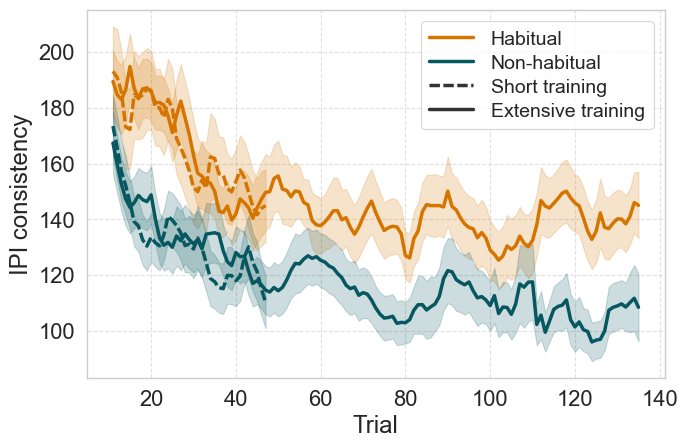

In [242]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})
palette=["#D57500", "#065760"]
fig_size_factor = 0.8
fig_size = (9*fig_size_factor, 6*fig_size_factor)

# merge isHabitual to IPI_consistency_data_by_trial
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial.merge(
    only_after_devalued_data[['sub', 'isHabitual']],
    on='sub',
    how='left'
)
# remove time==after:
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual[IPI_consistency_data_by_trial_isHabitual['time'] != 'after'].reset_index(drop=True)
# remove never_valued:
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual[IPI_consistency_data_by_trial_isHabitual['stim_condition'] != 'never_valued'].reset_index(drop=True)
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual.sort_values(by=['sub', 'block', 'trial']).reset_index(drop=True)
IPI_consistency_data_by_trial_isHabitual['abs_trial'] = IPI_consistency_data_by_trial_isHabitual.groupby(['sub']).cumcount() + 1

# Create a new flat legend without a title
custom_labels = {
    'Habitual': 'Habitual',
    'Non-habitual': 'Non-habitual',
    'short': 'Short training',
    'more_extensive': 'Extensive training'
}

# smoothing the IPI_abs_diff_sum
IPI_consistency_data_by_trial_isHabitual['smoothed_IPI_abs_diff_sum'] = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'group', 'isHabitual', 'stim_condition'])['IPI_abs_diff_sum'].transform(lambda x: x.rolling(window=10).mean())
# Now average across stim_abs_trial per sub:
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'group', 'isHabitual', 'stim_abs_trial']).agg({'smoothed_IPI_abs_diff_sum': 'mean'}).reset_index()

fig, axe = plt.subplots(1, 1, figsize=fig_size)
sns.lineplot(
    data=IPI_consistency_data_by_trial_isHabitual,
    x='stim_abs_trial',
    y='smoothed_IPI_abs_diff_sum',
    hue='isHabitual',
    style='group',
    palette=palette,
    legend='full',
    errorbar=('se', 1),
    dashes={'short': (3, 1), 'more_extensive': ''},
    ax=axe
)
axe.set_xlabel('Trial')
axe.set_ylabel('IPI consistency')
# Remove Seaborn's automatic legend that includes titles
if axe.legend_:
    axe.legend_.remove()

# Get all handles and labels from the current plot
handles, labels = axe.get_legend_handles_labels()

unique = []
used = set()
for h, l in zip(handles, labels):
    if l not in used and l in custom_labels:
        unique.append((h, custom_labels[l]))
        used.add(l)

# Unpack and add clean legend without a title
if unique:
    handles_clean, labels_clean = zip(*unique)
    legend = axe.legend(handles_clean, labels_clean, loc='upper right', title=None, labelspacing=0.2)
    for text in legend.texts:
        text.set_fontsize(14)

axe.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### stats

In [243]:
# merge isHabitual to IPI_consistency_data_by_trial
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial.merge(
    only_after_devalued_data[['sub', 'isHabitual']],
    on='sub',
    how='left'
)
# remove time==after:
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual[IPI_consistency_data_by_trial_isHabitual['time'] != 'after'].reset_index(drop=True)
# remove never_valued:
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual[IPI_consistency_data_by_trial_isHabitual['stim_condition'] != 'never_valued'].reset_index(drop=True)
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual.sort_values(by=['sub', 'block', 'trial']).reset_index(drop=True)
IPI_consistency_data_by_trial_isHabitual['abs_trial'] = IPI_consistency_data_by_trial_isHabitual.groupby(['sub']).cumcount() + 1

IPI_consistency_per_abs_trial = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'stim_abs_trial', 'stim_condition', 'isHabitual', 'group']).agg({'IPI_abs_diff_sum': 'mean'}).reset_index()
IPI_consistency_per_abs_trial['stim_abs_trial'] = IPI_consistency_per_abs_trial.groupby(['sub', 'stim_condition']).cumcount() + 1
IPI_consistency_per_abs_trial = IPI_consistency_per_abs_trial.groupby(['sub', 'stim_abs_trial', 'isHabitual', 'group']).agg({'IPI_abs_diff_sum': 'mean'}).reset_index()

In [244]:
%%R -i IPI_consistency_per_abs_trial
library(car)
library(lme4)
library(lmerTest)

# Ensure factor coding before applying contrasts:
IPI_consistency_per_abs_trial$isHabitual <- factor(IPI_consistency_per_abs_trial$isHabitual, levels = c("Non-habitual", "Habitual"))
IPI_consistency_per_abs_trial$group <- factor(IPI_consistency_per_abs_trial$group, levels = c("short", "more_extensive"))
# effect coding:
contrasts(IPI_consistency_per_abs_trial$isHabitual) <- contr.sum(2)
contrasts(IPI_consistency_per_abs_trial$group) <- contr.sum(2)
# scale stim_abs_trial:
IPI_consistency_per_abs_trial$stim_abs_trial <- scale(IPI_consistency_per_abs_trial$stim_abs_trial)

model <- lmer(IPI_abs_diff_sum ~ stim_abs_trial*isHabitual*group + (1|sub), data = IPI_consistency_per_abs_trial)
print(summary(model))
Anova(model, type = "III")


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff_sum ~ stim_abs_trial * isHabitual * group + (1 |  
    sub)
   Data: IPI_consistency_per_abs_trial

REML criterion at convergence: 214735.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1355 -0.5610 -0.2510  0.2159 10.7385 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept)  2530     50.29  
 Residual             15706    125.32  
Number of obs: 17142, groups:  sub, 193

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                         122.5654     4.5547   349.1598  26.910
stim_abs_trial                      -38.8330     2.9741 16944.6947 -13.057
isHabitual1                         -14.7289     4.5547   349.1598  -3.234
group1                              -19.2912     4.5547   349.1598  -4.235
stim_abs_trial:isHabitual1            0.4131     2.9741 16944.6947   0.139
stim_ab

## ==========================================
## Effects of devaluation on Automaticity (Fig. 5)
## ==========================================

### Automaticity before vs. after outcome devaluation

#### Fig. 5A

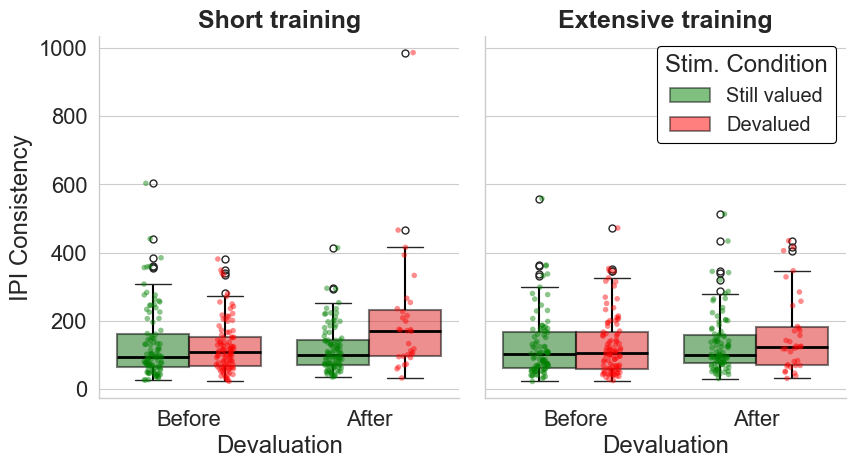

In [245]:
def plotGroupedBoxesWithFacets_subjectMeans(
    data,
    var_of_interest='IPI_abs_diff_sum',
    time_var='time',
    var_of_comparison='stim_condition',
    group_var='group',
    subject_var='sub',                    
    x_order=['Before', 'After'],
    hue_order=['still_valued', 'devalued'],
    palette_colors={'still_valued': 'green', 'devalued': 'red'},
    y_label='IPI Consistency',
    x_label='Devaluation',
    alpha=0.6,                           
    point_alpha=0.45,                
    point_size=4,
):

    df = data.copy()
    df = df[df[var_of_comparison].isin(hue_order)]
    df = df.dropna(subset=[var_of_interest])
    df[time_var] = df[time_var].replace({'before': 'Before', 'after': 'After'})
    df[time_var] = pd.Categorical(df[time_var], categories=x_order, ordered=True)

    summary = (df.groupby([group_var, subject_var, time_var, var_of_comparison], observed=False)
                 [var_of_interest].mean().reset_index())

    # --- boxplots over *subject means* ---
    g = sns.catplot(
        data=summary,
        x=time_var,
        y=var_of_interest,
        hue=var_of_comparison,
        col=group_var,
        col_order=['short', 'more_extensive'],
        kind='box',
        order=x_order,
        hue_order=hue_order,
        palette=palette_colors,
        showcaps=True,
        boxprops={'alpha': alpha, 'edgecolor': 'black', 'linewidth': 1.5},
        whiskerprops={'linewidth': 1.5, 'color': 'black'},
        medianprops={'linewidth': 2, 'color': 'black'},
        height=5,
        aspect=0.7,
        sharey=True
    )

    # --- Overlay the same subject-mean points ---
    for ax, title in zip(g.axes.flat, g.col_names):
        grp_summary = summary[summary[group_var] == title]
        sns.stripplot(
            data=grp_summary,
            x=time_var,
            y=var_of_interest,
            hue=var_of_comparison,
            hue_order=hue_order,
            order=x_order,
            palette=palette_colors,
            dodge=True,
            jitter=True,
            alpha=point_alpha,
            size=point_size,
            ax=ax
        )
        ax.get_legend().remove()

    # --- Labels & titles ---
    g.set_axis_labels(x_label, y_label)
    title_map = {'short': 'Short training', 'more_extensive': 'Extensive training'}
    for ax, title in zip(g.axes.flat, g.col_names):
        ax.set_title(title_map.get(title, title), weight='bold', fontsize=18)

    # --- Custom legend ---
    g._legend.remove()
    handles = [
        mpatches.Patch(
            facecolor=palette_colors[hue_order[0]],
            edgecolor='black',
            label=hue_order[0].replace('_', ' ').capitalize(),
            linewidth=1.2,
            alpha=alpha
        ),
        mpatches.Patch(
            facecolor=palette_colors[hue_order[1]],
            edgecolor='black',
            label=hue_order[1].replace('_', ' ').capitalize(),
            linewidth=1.2,
            alpha=alpha
        )
    ]
    # place legend on the right subplot (col=1)
    g.axes[0][1].legend(
        handles=handles,
        title="Stim. Condition",
        loc='upper right',
        frameon=True,
        framealpha=1,
        edgecolor='black',
        fontsize='small',
    )

    plt.tight_layout()
    plt.show()

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.8)

plotGroupedBoxesWithFacets_subjectMeans(
    data=IPI_consistency_data_by_trial,
    var_of_interest='IPI_abs_diff_sum',
    time_var='time',
    var_of_comparison='stim_condition',
    group_var='group',
    x_order = ['Before', 'After'],  # update x_order to match
    hue_order=['still_valued', 'devalued'],
    palette_colors={'still_valued': 'green', 'devalued': 'red'},
    y_label='IPI Consistency',
    x_label='Devaluation',
    alpha=0.5,
)

#### stats

In [246]:
ME_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['phase'].notnull()) & (IPI_consistency_data_by_trial['stim_condition'] != 'never_valued')].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['group', 'sub', 'phase', 'stim_condition', 'IPI_abs_diff_sum']]
ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """
library(lme4)
library(lmerTest)
library(car)
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
# scale the DV:
ME_data$IPI_abs_diff_sum <- scale(ME_data$IPI_abs_diff_sum)

model <- lmer(IPI_abs_diff_sum ~ group * time * stim_condition + (1| sub), data = ME_data)
print(summary(model))

# change reference point:
ME_data$group <- relevel(ME_data$group, ref = "more_extensive")
model <- lmer(IPI_abs_diff_sum ~ group * time * stim_condition + (1| sub), data = ME_data)
print(summary(model))

# now effect coding:
contrasts(ME_data$group) <- contr.sum(2)
contrasts(ME_data$stim_condition) <- contr.sum(2)
contrasts(ME_data$time) <- contr.sum(2)
model <- lmer(IPI_abs_diff_sum ~ group * time * stim_condition + (1| sub), data = ME_data)
print(summary(model))
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff_sum ~ group * time * stim_condition + (1 | sub)
   Data: ME_data

REML criterion at convergence: 24360.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8282 -0.4537 -0.2275  0.0787 12.3262 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09991  0.3161  
 Residual             0.90179  0.9496  
Number of obs: 8772, groups:  sub, 193

Fixed effects:
                                                       Estimate Std. Error
(Intercept)                                             0.02059    0.04347
groupmore_extensive                                    -0.03655    0.06188
timeafter                                              -0.07605    0.03615
stim_conditiondevalued                                 -0.03448    0.04158
groupmore_extensive:timeafter                           0.09306    0.05149
groupmore_extensive:stim_conditiondevalued 

### Modeling (with post deval changes)

#### Only (first) test block

In [247]:
# add time to the data (IPI_consistency_data_by_trial):
IPI_consistency_data_by_trial.loc[:, 'time'] = IPI_consistency_data_by_trial['phase'].apply(lambda x: 'before' if x == 'pre_test' else np.nan)
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'test', 'time'] = 'after'
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'reacquisition', 'time'] = 'after'

In [248]:
# NOTE: THIS is with only the the test phase. But results hold when using all test blocks (see below)
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

var = 'IPI_abs_diff_sum'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['rewardType'] != 'rock') & (IPI_consistency_data_by_trial['blockType'] != 'gambles_only')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'jump_by', 'transition_steepness', 'relative_improvement_accomplished', 'actual_jump', 'transition_point', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    if sub % 30 == 0:
        print(sub)
    for stim_condition in relevant_trial_data['stim_condition'].unique():
        # prepare sub data:
        # ------------------------
        data = relevant_trial_data[(relevant_trial_data['sub'] == sub) & (relevant_trial_data['stim_condition'] == stim_condition) & (relevant_trial_data['phase'] != 'reacquisition')]
        data = data.copy()
        data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
        data = data[data['smoothed_data'].notna()].reset_index(drop=True)
        # re-create the stim_abs_trial:
        data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()

        x_data = data['stim_abs_trial']
        y_data_smoothed = data['smoothed_data']
        if data[data['time'] == 'after'].shape[0] == 0:
            point_of_first_deval_trial = np.nan
            # Calculate initial guesses from the data:
            y_start = y_data_smoothed.iloc[0]
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            p0 = (asymp_guess, improvement_guess, 0.01)

            popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0], [3500, 3500, 1000]))
            y_predicted = exponential_decay(x_data, *popt)
            actual_jump_by = np.nan
        else:
            point_of_first_deval_trial = data[data['time'] == 'after'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5
            def exponential_decay_to_quick_growth(x, asymp_to, improvement, alpha, jump_by, transition_steepness):
                decay = asymp_to + improvement * np.exp(-alpha * x)
                switch = 1/(1+np.exp(-transition_steepness*(x-point_of_first_deval_trial)))
                growth = asymp_to + jump_by * switch
                return (1-switch)*decay + switch*growth

            # Calculate initial guesses from the data
            y_start = y_data_smoothed.iloc[0]
            # Use the value at the point of devaluation instead of the last trial
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            # calc jump_by_initial_guess as the difference between after vs. before devaluation:
            jump_by_initial_guess = data.loc[data.time=='after', 'IPI_abs_diff_sum'].mean() - data.loc[data.time=='before', 'IPI_abs_diff_sum'].mean()
            p0 = (asymp_guess, improvement_guess, 0.01, jump_by_initial_guess, 10)
            popt, pcov = curve_fit(exponential_decay_to_quick_growth, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0, -3500, 1], [3500, 3500, 1000, 3500, 1000]))
            y_predicted = exponential_decay_to_quick_growth(x_data, *popt)
            # GET the actual jump (according to the current position on the exponent):
            y_at_change_point = exponential_decay_to_quick_growth(point_of_first_deval_trial, *popt)
            actual_jump_by = -1*(popt[3] - (y_at_change_point - popt[0]))

        last_training_point = data[data['time'] != 'after'].iloc[-1]['stim_abs_trial']

        # Calculate the residuals, sum of squares of residuals and the total sum of squares
        residuals = y_data_smoothed - y_predicted
        ss_residuals = np.sum(residuals**2)
        ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
        # calculate the R squared:
        r_squared = 1 - (ss_residuals / ss_total)

        # relative gain of performance ('improvement') by the final point in training (according to the model):
        end_of_training_pred = y_predicted[last_training_point]
        relative_improvement_accomplished = 1 - ((y_predicted[last_training_point] - popt[0]) / popt[1])

        results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])


print(f'mean R^2: {results_df.r_squared.mean().round(3)}')
warnings.resetwarnings()


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3965172023.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])


1020


1050
1080
3030
3060
3090
mean R^2: 0.207


##### Fig. 5B

Processing sub 1003, stim_condition still_valued
Processing sub 1003, stim_condition devalued


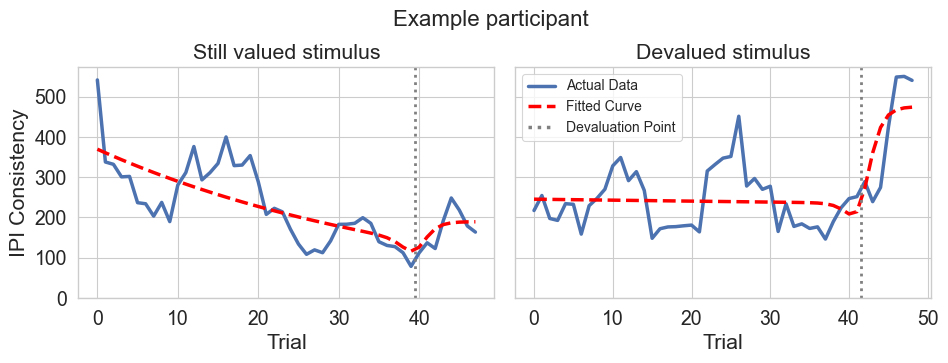

In [249]:
sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

sub = 1003
fig, axes = plt.subplots(1, 2, figsize=(11, 3), sharey=True)
fig.suptitle(f"Example participant", fontsize=16, y=1.07)

plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space

for i, stim_condition in enumerate(['still_valued', 'devalued']):
    print(f"Processing sub {sub}, stim_condition {stim_condition}")
    data_cond = relevant_trial_data[(relevant_trial_data['sub'] == sub) & 
                                (relevant_trial_data['stim_condition'] == stim_condition) &
                                (relevant_trial_data['phase'] != 'reacquisition')].copy()

    data_cond['smoothed_data'] = data_cond.groupby('stim_condition')[var].transform(
        lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    data_cond = data_cond[data_cond['smoothed_data'].notna()].reset_index(drop=True)
    data_cond['stim_abs_trial'] = data_cond.groupby(grouping_factos).cumcount()

    x_data = data_cond['stim_abs_trial']
    y_data_smoothed = data_cond['smoothed_data']

    if data_cond[data_cond['time'] == 'after'].shape[0] == 0:
        y_start = y_data_smoothed.iloc[0]
        y_end = y_data_smoothed.iloc[-1]
        improvement_guess = abs(y_start - y_end)
        asymp_guess = y_end
        p0 = (asymp_guess, improvement_guess, 0.01)
        popt, _ = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                            bounds=([0, 0, 0], [3500, 3500, 1000]))
        y_predicted = exponential_decay(x_data, *popt)
        point_of_first_deval_trial = np.nan
    else:
        point_of_first_deval_trial = data_cond[data_cond['time'] == 'after'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial'] - 0.5
        def exponential_decay_to_quick_growth(x, asymp_to, improvement, alpha, jump_by, transition_steepness):
            decay = asymp_to + improvement * np.exp(-alpha * x)
            switch = 1 / (1 + np.exp(-transition_steepness * (x - point_of_first_deval_trial)))
            growth = asymp_to + jump_by * switch
            return (1 - switch) * decay + switch * growth

        y_start = y_data_smoothed.iloc[0]
        y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial - 0.5)] if int(point_of_first_deval_trial - 0.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
        improvement_guess = abs(y_start - y_end)
        asymp_guess = y_end
        jump_guess = data_cond.loc[data_cond.time == 'after', var].mean() - data_cond.loc[data_cond.time == 'before', var].mean()
        p0 = (asymp_guess, improvement_guess, 0.01, jump_guess, 10)
        popt, _ = curve_fit(exponential_decay_to_quick_growth, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                            bounds=([0, 0, 0, -3500, 1], [3500, 3500, 1000, 3500, 1000]))
        y_predicted = exponential_decay_to_quick_growth(x_data, *popt)

    ax = axes[i]
    sns.lineplot(x=x_data, y=y_data_smoothed, ax=ax, label=None)  # no label = no auto legend
    sns.lineplot(x=x_data, y=y_predicted, ax=ax, color='red', linestyle='--', label=None)

    if not np.isnan(point_of_first_deval_trial):
        ax.axvline(x=point_of_first_deval_trial, color='gray', linestyle=':', linewidth=2)

    ax.set_title(f"{stim_condition.replace('_', ' ').capitalize()} stimulus")
    ax.set_xlabel("Trial")
    if i == 0:
        ax.set_ylabel("IPI Consistency")
    else:
        ax.set_ylabel("")

    # Set y ticks every 100
    ax.set_yticks(np.arange(0, ax.get_ylim()[1] + 1, 100))

axes[1].legend(
    handles=[
        plt.Line2D([0], [0], color='C0', label='Actual Data'),
        plt.Line2D([0], [0], color='red', linestyle='--', label='Fitted Curve'),
        plt.Line2D([0], [0], color='gray', linestyle=':', label='Devaluation Point')
    ],
    loc='upper left',
    fontsize=10
)

plt.show()

In [250]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df, on=['sub', 'group', 'stim_condition'], how='left')

##### Fig. 5C

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3456790309.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Short training', 'Extensive training'])


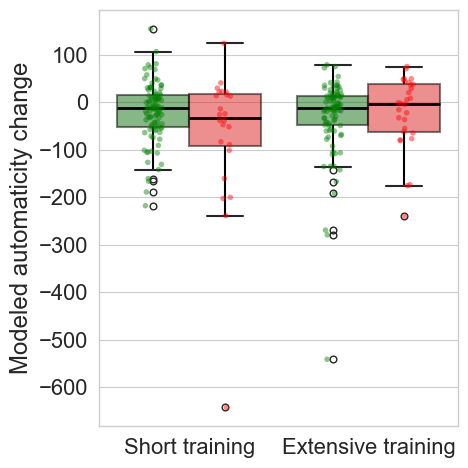

In [251]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 2})

hue_order   = ['still_valued','devalued']
measure = 'actual_jump'
results_df_plot = results_df[results_df[measure].notna()]
palette = {'still_valued': 'green', 'devalued': 'red'}
alpha = 0.5

# ---------------------------
# Boxplot
# ---------------------------
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    data=results_df_plot,
    x='group',
    y=measure,
    hue='stim_condition',
    hue_order=hue_order,
    palette=palette,
    linewidth=1.5,
    boxprops={'alpha': alpha, 'edgecolor': 'black', 'linewidth': 1.5},
    whiskerprops={'linewidth': 1.5, 'color': 'black'},
    medianprops={'linewidth': 2, 'color': 'black'},
    ax=ax
)

# --- Overlay the same subject-mean points ---
sns.stripplot(
    data=results_df_plot,
    x='group',
    y=measure,
    hue='stim_condition',
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    jitter=True,
    alpha=0.45,
    size=4,
    ax=ax
)

# Labeling and styling
ax.set_ylabel('Modeled automaticity change')
ax.set_xlabel('')
ax.set_xticklabels(['Short training', 'Extensive training'])
ax.legend_.remove()
fig.tight_layout()
plt.show()

##### stats

In [252]:
%%R -i results_df
results_df

library(lme4)
library(lmerTest)
library(car)
# remove nans of actual_jump:
ME_data <- results_df[!is.na(results_df$actual_jump), ]
# factor variables:
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
#scale the actual_jump:
ME_data$actual_jump <- scale(ME_data$actual_jump)

model <- lmer(actual_jump ~ stim_condition*group + (1| sub), data = ME_data)
print(summary(model))

# change reference to extensive:
ME_data$group <- relevel(ME_data$group, ref = "more_extensive")
model <- lmer(actual_jump ~ stim_condition*group + (1| sub), data = ME_data)
print(summary(model))

# effect coding:
ME_data$group <- ifelse(ME_data$group == "short", -1, 1)
ME_data$stim_condition <- ifelse(ME_data$stim_condition == "still_valued", -1, 1)
model <- lmer(actual_jump ~ stim_condition*group + (1| sub), data = ME_data)
print(summary(model))
print(Anova(model, type = "III"))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: actual_jump ~ stim_condition * group + (1 | sub)
   Data: ME_data

REML criterion at convergence: 687.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.6892 -0.3380  0.1949  0.5508  2.2409 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.03818  0.1954  
 Residual             0.94623  0.9727  
Number of obs: 242, groups:  sub, 189

Fixed effects:
                                           Estimate Std. Error       df t value
(Intercept)                                  0.1073     0.1013 237.9117   1.059
stim_conditiondevalued                      -0.5702     0.2246 189.4909  -2.539
groupmore_extensive                         -0.1285

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


     0.1444 237.9117  -0.890
stim_conditiondevalued:groupmore_extensive   0.6949     0.3068 183.5369   2.265
                                           Pr(>|t|)  
(Intercept)                                  0.2906  
stim_conditiondevalued                       0.0119 *
groupmore_extensive                          0.3741  
stim_conditiondevalued:groupmore_extensive   0.0247 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) stm_cn grpmr_
stm_cndtndv -0.433              
grpmr_xtnsv -0.701  0.304       
stm_cndtn:_  0.317 -0.732 -0.452
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: actual_jump ~ stim_condition * group + (1 | sub)
   Data: ME_data

REML criterion at convergence: 687.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.6892 -0.3380  0.1949  0.5508  2.2409 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.03818  0.

#### All post devaluation blocks

In [253]:
IPI_consistency_data_by_trial.loc[:, 'time'] = IPI_consistency_data_by_trial['phase'].apply(lambda x: 'before' if x == 'pre_test' else np.nan)
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'test', 'time'] = 'after'
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'reacquisition', 'time'] = 'after'

In [254]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

var = 'IPI_abs_diff_sum'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['rewardType'] != 'rock') & (IPI_consistency_data_by_trial['blockType'] != 'gambles_only')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'jump_by', 'transition_steepness', 'relative_improvement_accomplished', 'actual_jump', 'transition_point', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    if sub % 30 == 0:
        print(sub)
    for stim_condition in relevant_trial_data['stim_condition'].unique():
        # prepare sub data:
        # ------------------------
        data = relevant_trial_data[(relevant_trial_data['sub'] == sub) & (relevant_trial_data['stim_condition'] == stim_condition)]
        data = data.copy()
        data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
        data = data[data['smoothed_data'].notna()].reset_index(drop=True)
        # re-create the stim_abs_trial:
        data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()

        x_data = data['stim_abs_trial']
        y_data_smoothed = data['smoothed_data']
        if data[data['time'] == 'after'].shape[0] == 0:
            point_of_first_deval_trial = np.nan
            # Calculate initial guesses from the data:
            y_start = y_data_smoothed.iloc[0]
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            p0 = (asymp_guess, improvement_guess, 0.01)

            popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0], [3500, 3500, 1000]))
            y_predicted = exponential_decay(x_data, *popt)
            actual_jump_by = np.nan
        else:
            point_of_first_deval_trial = data[data['time'] == 'after'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5
            def exponential_decay_to_quick_growth(x, asymp_to, improvement, alpha, jump_by, transition_steepness):
                decay = asymp_to + improvement * np.exp(-alpha * x)
                switch = 1/(1+np.exp(-transition_steepness*(x-point_of_first_deval_trial)))
                growth = asymp_to + jump_by * switch
                return (1-switch)*decay + switch*growth

            # Calculate initial guesses from the data
            y_start = y_data_smoothed.iloc[0]
            # Use the value at the point of devaluation instead of the last trial
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            # calc jump_by_initial_guess as the difference between after vs. before devaluation:
            jump_by_initial_guess = data.loc[data.time=='after', 'IPI_abs_diff_sum'].mean() - data.loc[data.time=='before', 'IPI_abs_diff_sum'].mean()
            p0 = (asymp_guess, improvement_guess, 0.01, jump_by_initial_guess, 10)
            popt, pcov = curve_fit(exponential_decay_to_quick_growth, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0, -3500, 1], [3500, 3500, 1000, 3500, 1000]))
            y_predicted = exponential_decay_to_quick_growth(x_data, *popt)
            # GET the actual jump (according to the current position on the exponent):
            y_at_change_point = exponential_decay_to_quick_growth(point_of_first_deval_trial, *popt)
            actual_jump_by = -1*(popt[3] - (y_at_change_point - popt[0]))
        last_training_point = data[data['time'] != 'after'].iloc[-1]['stim_abs_trial']

        # Calculate the residuals, sum of squares of residuals and the total sum of squares
        residuals = y_data_smoothed - y_predicted
        ss_residuals = np.sum(residuals**2)
        ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
        # calculate the R squared:
        r_squared = 1 - (ss_residuals / ss_total)

        # relative gain of performance ('improvement') by the final point in training (according to the model):
        end_of_training_pred = y_predicted[last_training_point]
        relative_improvement_accomplished = 1 - ((y_predicted[last_training_point] - popt[0]) / popt[1])

        results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')
warnings.resetwarnings()


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/1953018242.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])


1020


1050
1080
3030
3060
3090
mean R^2: 0.206


In [255]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df, on=['sub', 'group', 'stim_condition'], how='left')

##### stats

In [256]:
%%R -i results_df

library(lme4)
library(lmerTest)
library(car)
# remove nans of actual_jump:
ME_data <- results_df[!is.na(results_df$actual_jump), ]
# factor variables:
ME_data$group <- as.factor(ME_data$group)
ME_data$group <- relevel(ME_data$group, ref = "short")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
#scale the actual_jump:
ME_data$actual_jump <- scale(ME_data$actual_jump)

# effect coding:
ME_data$group <- ifelse(ME_data$group == "short", -1, 1)
ME_data$stim_condition <- ifelse(ME_data$stim_condition == "still_valued", -1, 1)
model <- lmer(actual_jump ~ stim_condition*group + (1| sub), data = ME_data)
print(summary(model))
print(Anova(model, type = "III"))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: actual_jump ~ stim_condition * group + (1 | sub)
   Data: ME_data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '




REML criterion at convergence: 739.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2995 -0.3100  0.1605  0.5137  2.4361 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.07164  0.2676  
 Residual             0.90733  0.9525  
Number of obs: 259, groups:  sub, 193

Fixed effects:
                      Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)           -0.07754    0.07185 201.70941  -1.079   0.2818  
stim_condition        -0.15165    0.06922 181.59355  -2.191   0.0297 *
group                  0.06872    0.07185 201.70941   0.956   0.3400  
stim_condition:group   0.14277    0.06922 181.59355   2.063   0.0406 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) stm_cn group 
stim_condtn  0.491              
group       -0.039 -0.049       
stm_cndtn:g -0.049 -0.043  0.491
Analysis of Deviance Table (Type III Wald chisquare tests)

Response: actual_jump
 

## ==========================================
## Relationships between habit expression and other automaticity/performance measures (Table S1)
## ==========================================


### -- RT --

#### Model training

In [257]:
var = 'SRO_rt_of_SRO_key'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])
    
    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/279943433.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.418


In [258]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with RT: 0.132, p-value: 0.0332


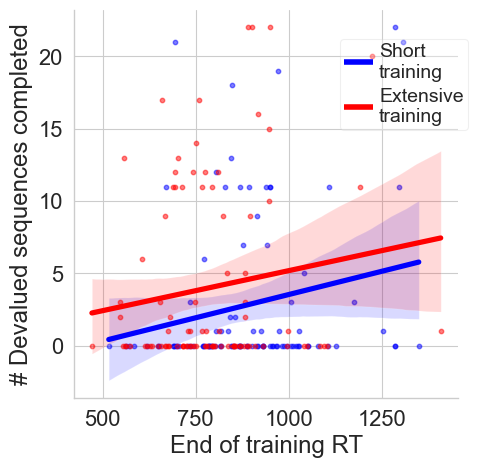

In [259]:



sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with RT: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', hue_order=['short', 'more_extensive'], palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training RT')

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], lw=4, label='Short\ntraining', solid_capstyle='butt'),
    Line2D([0], [0], color=pallette[1], lw=4, label='Extensive\ntraining', solid_capstyle='butt')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),  # Move slightly right and down
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)


### -- Sequence Completion Time --

#### Model training

In [260]:
var = 'SRO_seq_completion_time'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/1995656693.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.509


In [261]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation: 0.106, p-value: 0.070


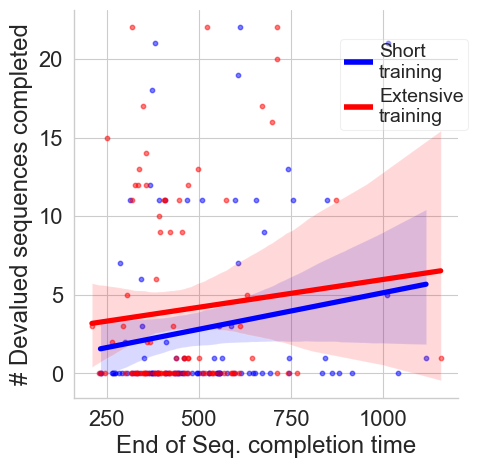

In [262]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', hue_order=['short', 'more_extensive'], palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of Seq. completion time')

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], lw=4, label='Short\ntraining', solid_capstyle='butt'),
    Line2D([0], [0], color=pallette[1], lw=4, label='Extensive\ntraining', solid_capstyle='butt')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),  # Move slightly right and down
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)

pearson_corr, p_value = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f'Pearson correlation: {pearson_corr:.3f}, p-value: {p_value:.3f}')


### -- Sequence completion time from the START

#### Model training

In [263]:
var = 'SRO_seq_completion_time_from_start'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])
    
    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3933366025.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.528


In [264]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation: 0.144, p-value: 0.023


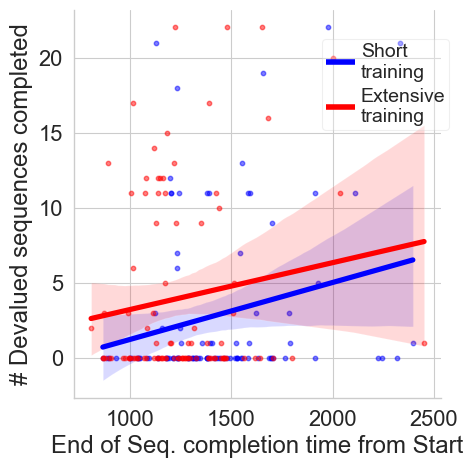

In [265]:



sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', hue_order=['short', 'more_extensive'], palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of Seq. completion time from Start')

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], lw=4, label='Short\ntraining', solid_capstyle='butt'),
    Line2D([0], [0], color=pallette[1], lw=4, label='Extensive\ntraining', solid_capstyle='butt')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),  # Move slightly right and down
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)

# now pearson:
pearson_corr, p_value = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f'Pearson correlation: {pearson_corr:.3f}, p-value: {p_value:.3f}')

### --- RT STD ---

#### Model training

In [266]:
var = 'SRO_rt_of_SRO_key_local_std'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
stim_condition = var_of_comparison

relevant_trial_data = prepare_local_std(relevant_trial_data, var_of_comparison=var_of_comparison, var=var, smoothing_window=5)

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/2949520714.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.232


In [267]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.153, p-value: 0.0168


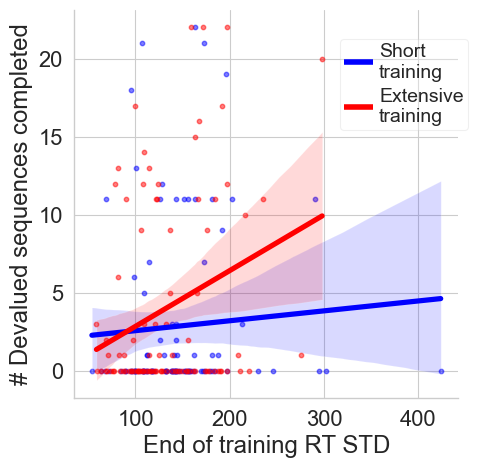

In [268]:



sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', hue_order=['short', 'more_extensive'], palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training RT STD')

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], lw=4, label='Short\ntraining', solid_capstyle='butt'),
    Line2D([0], [0], color=pallette[1], lw=4, label='Extensive\ntraining', solid_capstyle='butt')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),  # Move slightly right and down
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)


### --- Sequence completin time STD ---

#### Model training

In [269]:
var = 'SRO_seq_completion_time_local_std'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
stim_condition = var_of_comparison

relevant_trial_data = prepare_local_std(relevant_trial_data, var_of_comparison=var_of_comparison, var=var, smoothing_window=5)

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])
    
    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3613727016.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.172


In [270]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.263, p-value: 0.0001


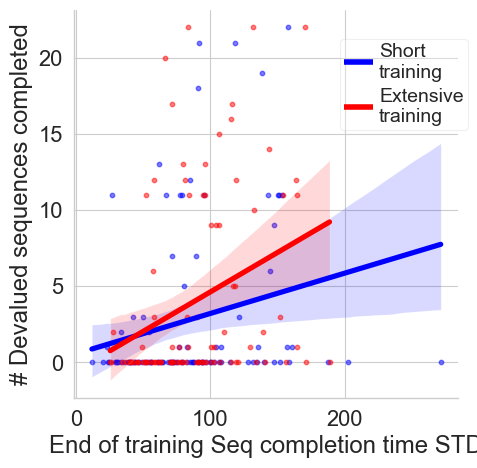

In [271]:



sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', hue_order=['short', 'more_extensive'], palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training Seq completion time STD')

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], lw=4, label='Short\ntraining', solid_capstyle='butt'),
    Line2D([0], [0], color=pallette[1], lw=4, label='Extensive\ntraining', solid_capstyle='butt')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),  # Move slightly right and down
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)


### --- Sequence completin time FROM START STD ---

#### Model training

In [272]:
var = 'SRO_seq_completion_time_from_start_local_std'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1 
min_period = None

if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
stim_condition = var_of_comparison

relevant_trial_data = prepare_local_std(relevant_trial_data, var_of_comparison=var_of_comparison, var=var, smoothing_window=5)

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2297/3760311161.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.16


In [273]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.192, p-value: 0.0037


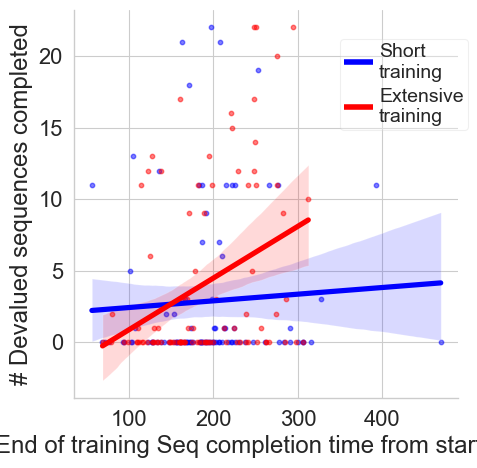

In [274]:



sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['blue', 'red']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', hue_order=['short', 'more_extensive'], palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training Seq completion time from start STD')

# Custom legend with lines
custom_lines = [
    Line2D([0], [0], color=pallette[0], lw=4, label='Short\ntraining', solid_capstyle='butt'),
    Line2D([0], [0], color=pallette[1], lw=4, label='Extensive\ntraining', solid_capstyle='butt')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),  # Move slightly right and down
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)
